In [1]:
import sys
import os
import json
import torch
from collections import OrderedDict
from model import MolVAE
from textdata import textdata
from utils import idx2smiles, eval_prior_samples, smiles_to_mol, mol_weight, mol_qed, mol_sas, mol_logp, \
                    smiles2mean, latent2smiles, create_smiles_lst, perturb_z, to_cuda_var, \
                    pairwise_dist,upper_tri_indexing
from lorentz_model import *
import numpy as np
import pandas as pd
import random
from rdkit import Chem
from rdkit import rdBase
rdBase.DisableLog('rdApp.error') #disable RDKit warning messages
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols


import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import umap

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy import spatial

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
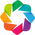

In [2]:
import holoviews as hv
from holoviews import opts, dim, Palette
hv.extension('bokeh')

opts.defaults(
    opts.Bars(xrotation=45, tools=['hover']),
    opts.BoxWhisker(width=600, height=400, xrotation=30, box_fill_color=Palette('Category20')),
    opts.Curve(width=600, height=400, tools=['hover']),
    opts.GridSpace(shared_yaxis=True),
    opts.Scatter(width=600, height=400, size=10, tools=['hover']),
    opts.NdOverlay(legend_position='left'))

In [3]:
### Currently, this function only works for Euclidean space. Vector operations (e.g. sum, inner product) are different
### in Hyperbolic space
def perturb_z(z, noise_norm, constant_norm=False):
    if noise_norm > 0.0:
        noise_vec = np.random.normal(0, 1, size=z.shape)
        noise_vec = noise_vec / np.linalg.norm(noise_vec, axis=1).reshape(z.shape[0], 1)
        if constant_norm:
            return z + (noise_norm * noise_vec)
        else:
            noise_amp = np.random.uniform(0, noise_norm, size=(z.shape[0],1))
            return z + (noise_amp * noise_vec)
    else:
        return z

In [4]:
def dist_z(manifold_type, z1, z2):
    if manifold_type == 'Euclidean':
        d2 = torch.dist(z1, z2)
    elif manifold_type == 'Lorentz' :
        d2 = arccosh(-lorentz_product(z1,z2))
    return d2

In [5]:
def vae_pairwise_dist_hist(exp_name, num_mdls, input_smiles):
    dist_lst = []
    norm_lst = []
    for e in tqdm(range(num_mdls)):
        epoch = (e+1)*5
        exp_name = exp_name
        if epoch == 5:
            checkpoint = 'checkpoint_epoch005.model'
        else:
            checkpoint = 'checkpoint_epoch0'+str(epoch)+'.model'
            
        exp_dir = './experiments/SMILES/'
        config_path = os.path.join(exp_dir + exp_name, 'configs.json')
        checkpoint_path = os.path.join(exp_dir + exp_name, checkpoint)
        
        with open(config_path, 'r') as fp:
            configs = json.load(fp)
            fp.close()
            
        try:
            configs['prior_var']
        except:
            configs['prior_var'] = 1.0

        # prepare train, valid, test datasets
        datasets = OrderedDict()
        splits = ['train', 'valid', 'test']
        for split in splits:
            datasets[split] = textdata(directory=configs['data_dir'], split=split, vocab_file=configs['vocab_file'],
                                       max_sequence_length=configs['max_sequence_length'])

        #build model
        model = MolVAE(
            vocab_size=datasets['train'].vocab_size,
            embedding_size=datasets['train'].vocab_size,
            hidden_size=configs['hidden_size'],
            latent_size=configs['latent_size'],
            manifold_type=configs['manifold_type'],
            rnn_type=configs['rnn_type'],
            bidirectional=configs['bidirectional'],
            num_layers=configs['num_layers'],
            word_dropout_rate=configs['word_dropout_rate'],
            embedding_dropout_rate=configs['embedding_dropout_rate'],
            one_hot_rep=configs['one_hot_rep'],
            max_sequence_length=configs['max_sequence_length'],
            sos_idx=datasets['train'].sos_idx,
            eos_idx=datasets['train'].eos_idx,
            pad_idx=datasets['train'].pad_idx,
            unk_idx=datasets['train'].unk_idx,
            prior_var=configs['prior_var']
        )
        # load checkpoint
        model.load_state_dict(torch.load(checkpoint_path))
        if torch.cuda.is_available():
            model = model.cuda()
        model.eval()

        mu_lst = []
        for smi in input_smiles:
            try:
                mu, logv = smiles2mean(configs, smi, model)
                mu_lst.append(mu)
            except:
                pass

        mu_array = torch.stack(mu_lst).squeeze().cpu().detach().numpy()
        dist = pairwise_dist(configs['manifold_type'], mu_array)
        dist_lst.append(dist)
        
        if configs['manifold_type'] == 'Euclidean':
            norm_lst.append(np.linalg.norm(mu_array, ord=2, axis=1))
        elif configs['manifold_type'] == 'Lorentz':
            poincare_mu_array = lorentz_to_poincare(mu_array)
            norm_lst.append(np.linalg.norm(poincare_mu_array, ord=2, axis=1))
    return dist_lst, norm_lst

In [6]:
def vae_conditional_samples_quality(exp_name, num_mdls, input_smiles):

    validity_mean_lst = []
    exact_mean_lst = []
    tanimoto_mean_lst = []
    
    for e in tqdm(range(num_mdls)):
        epoch = (e+1)*5
        exp_name = exp_name
        if epoch == 5:
            checkpoint = 'checkpoint_epoch005.model'
        else:
            checkpoint = 'checkpoint_epoch0'+str(epoch)+'.model'

        exp_dir = './experiments/SMILES/'
        config_path = os.path.join(exp_dir + exp_name, 'configs.json')
        checkpoint_path = os.path.join(exp_dir + exp_name, checkpoint)

        with open(config_path, 'r') as fp:
            configs = json.load(fp)
            fp.close()

        try:
            configs['prior_var']
        except:
            configs['prior_var'] = 1.0

        # prepare train, valid, test datasets
        datasets = OrderedDict()
        splits = ['train', 'valid', 'test']
        for split in splits:
            datasets[split] = textdata(directory=configs['data_dir'], split=split, vocab_file=configs['vocab_file'],
                                       max_sequence_length=configs['max_sequence_length'])

        #build model
        model = MolVAE(
            vocab_size=datasets['train'].vocab_size,
            embedding_size=datasets['train'].vocab_size,
            hidden_size=configs['hidden_size'],
            latent_size=configs['latent_size'],
            manifold_type=configs['manifold_type'],
            rnn_type=configs['rnn_type'],
            bidirectional=configs['bidirectional'],
            num_layers=configs['num_layers'],
            word_dropout_rate=configs['word_dropout_rate'],
            embedding_dropout_rate=configs['embedding_dropout_rate'],
            one_hot_rep=configs['one_hot_rep'],
            max_sequence_length=configs['max_sequence_length'],
            sos_idx=datasets['train'].sos_idx,
            eos_idx=datasets['train'].eos_idx,
            pad_idx=datasets['train'].pad_idx,
            unk_idx=datasets['train'].unk_idx,
            prior_var=configs['prior_var']
        )
        # load checkpoint
        model.load_state_dict(torch.load(checkpoint_path))
        if torch.cuda.is_available():
            model = model.cuda()
        model.eval()

        smiles_sample_lst = []
        for smi in input_smiles:
            mean, logv = smiles2mean(configs, smi, model)
            samples_idx, z = model.inference(n=mean.shape[0], sampling_mode='greedy', z=mean)
            smi_sample = idx2smiles(configs, samples_idx)[0]
            # calculate target molecule metrics
            mol_t = smiles_to_mol(smi)
            fp_t = FingerprintMols.FingerprintMol(mol_t)
            # calculate sampled molecule metrics
            if smiles_to_mol(smi_sample) is not None:
                mol_s = smiles_to_mol(smi_sample)
                validty = 1
                fp_s = FingerprintMols.FingerprintMol(mol_s)
                tanimoto = DataStructs.FingerprintSimilarity(fp_t,fp_s)
            else:
                validty = 0
                fp_s = None
                tanimoto = 0
            smiles_sample_lst.append([smi, smi_sample, validty, smi==smi_sample, tanimoto])
        
        smi_sample_df = pd.DataFrame(smiles_sample_lst, columns=['SMILES_T', 'SMILES_S', 'VALIDITY', 'EXACT', 'TANIMOTO'])
        validity_mean_lst.append(smi_sample_df['VALIDITY'].mean())
        exact_mean_lst.append(smi_sample_df['EXACT'].mean())
        tanimoto_mean_lst.append(smi_sample_df['TANIMOTO'].mean())
        
    return validity_mean_lst, exact_mean_lst, tanimoto_mean_lst

In [7]:
def lower(x):
    return x.lower()

### Select a pre-trained model

In [145]:
exp_name = 'exp_a_8'
checkpoint = 'checkpoint_epoch060.model'

In [146]:
exp_dir = './experiments/SMILES/'
config_path = os.path.join(exp_dir + exp_name, 'configs.json')
checkpoint_path = os.path.join(exp_dir + exp_name, checkpoint)

In [147]:
with open(config_path, 'r') as fp:
    configs = json.load(fp)
    fp.close()
try:
    configs['prior_var']
except:
    configs['prior_var'] = 1.0
configs

{'data_dir': './data',
 'data_file': '250k_rndm_zinc_drugs_clean.smi',
 'vocab_file': 'zinc_char_list.json',
 'checkpoint_dir': './experiments/SMILES',
 'experiment_name': 'exp_a_8',
 'limit': 249456,
 'batch_size': 128,
 'epochs': 60,
 'max_sequence_length': 120,
 'learning_rate': 0.0003,
 'max_norm': 1000000000000.0,
 'wd': 0.0,
 'manifold_type': 'Lorentz',
 'rnn_type': 'gru',
 'bidirectional': False,
 'num_layers': 1,
 'hidden_size': 500,
 'latent_size': 40,
 'one_hot_rep': True,
 'word_dropout_rate': 0.2,
 'embedding_dropout_rate': 0.0,
 'anneal_function': 'logistic',
 'k': 0.51,
 'x0': 29.0,
 'num_workers': 1,
 'logging_steps': 1,
 'save_per_epochs': 5,
 'new_training': True,
 'new_annealing': False,
 'checkpoint': 'checkpoint_epoch100.model',
 'trained_epochs': 100,
 'prior_var': 1.0}

In [148]:
# prepare train, valid, test datasets
datasets = OrderedDict()
splits = ['train', 'valid', 'test']
for split in splits:
    datasets[split] = textdata(directory=configs['data_dir'], split=split, vocab_file=configs['vocab_file'],
                               max_sequence_length=configs['max_sequence_length'])
#build model
model = MolVAE(
    vocab_size=datasets['train'].vocab_size,
    embedding_size=datasets['train'].vocab_size,
    hidden_size=configs['hidden_size'],
    latent_size=configs['latent_size'],
    manifold_type=configs['manifold_type'],
    rnn_type=configs['rnn_type'],
    bidirectional=configs['bidirectional'],
    num_layers=configs['num_layers'],
    word_dropout_rate=configs['word_dropout_rate'],
    embedding_dropout_rate=configs['embedding_dropout_rate'],
    one_hot_rep=configs['one_hot_rep'],
    max_sequence_length=configs['max_sequence_length'],
    sos_idx=datasets['train'].sos_idx,
    eos_idx=datasets['train'].eos_idx,
    pad_idx=datasets['train'].pad_idx,
    unk_idx=datasets['train'].unk_idx,
    prior_var=configs['prior_var']
)
# load checkpoint
model.load_state_dict(torch.load(checkpoint_path))
if torch.cuda.is_available():
    model = model.cuda()
model.eval()

MolVAE(
  (encoder_rnn): GRU(39, 500, batch_first=True)
  (decoder_rnn): GRU(39, 500, batch_first=True)
  (hidden2mean): Linear(in_features=500, out_features=40, bias=True)
  (hidden2logv): Linear(in_features=500, out_features=40, bias=True)
  (latent2hidden): Linear(in_features=41, out_features=500, bias=True)
  (outputs2vocab): Linear(in_features=500, out_features=39, bias=True)
)

## Sample decoded from latent space ~ p(z)

In [149]:
nsample = 1000

In [150]:
samples_idx, z = model.inference(n=nsample, sampling_mode='greedy', z=None)
prior_smiles_sample = idx2smiles(configs, samples_idx)

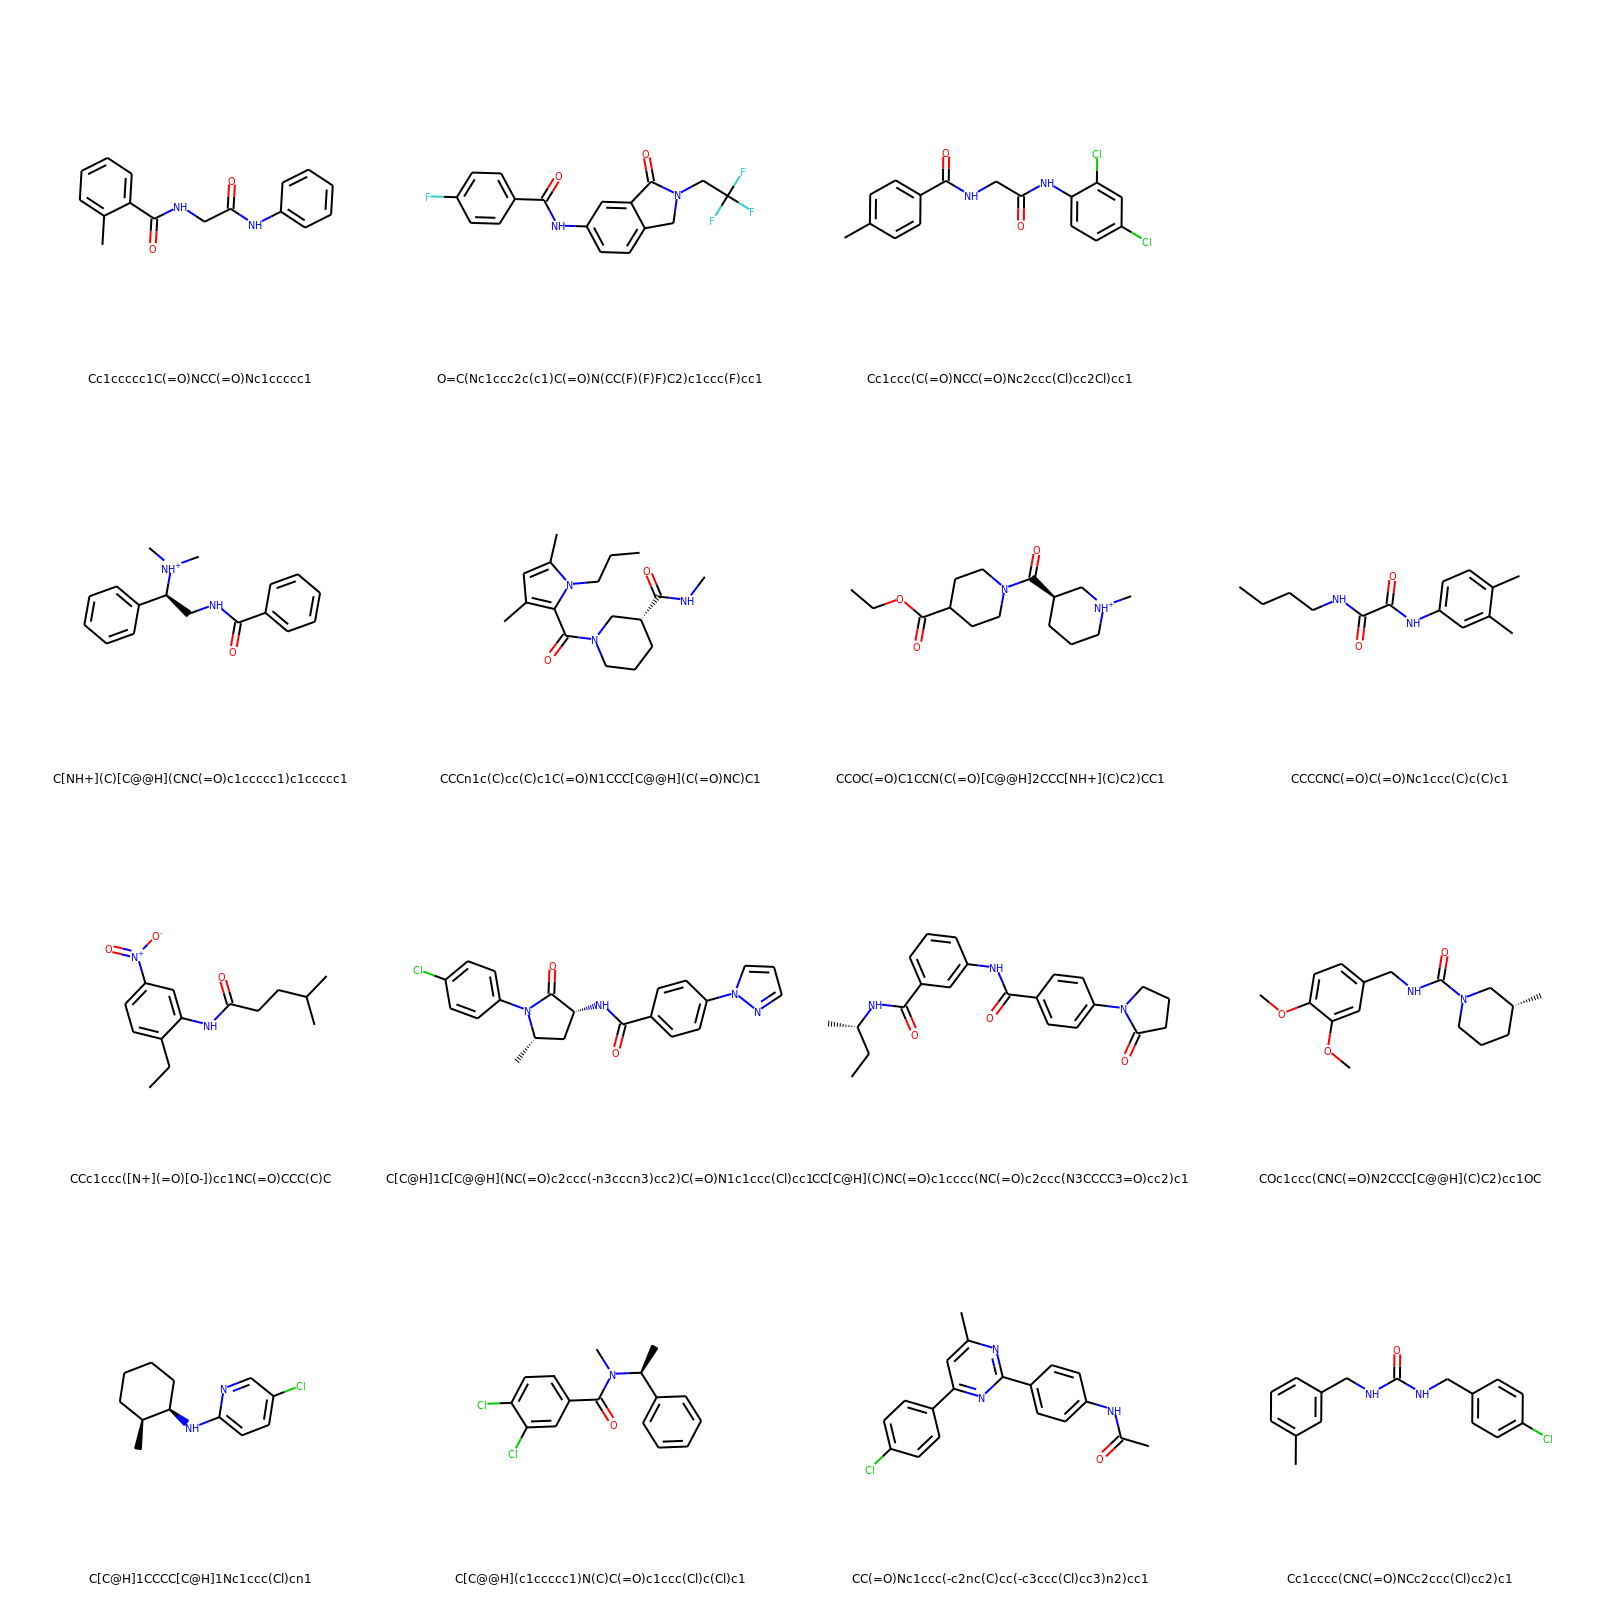

In [151]:
smiles_grid = prior_smiles_sample[:16]
mol_grid=[]
for smi in smiles_grid:
    try:
        mol_grid.append(Chem.MolFromSmiles(smi))
    except:
        pass

Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=4,subImgSize=(400,400), legends=smiles_grid)

### Validty, Uniqueness, Novelty

In [152]:
perc_valid, perc_chem_valid, perc_unique, perc_novel = \
eval_prior_samples(configs, prior_smiles_sample)

In [153]:
print('%s%% sampled SMILES from prior distribution are valid.' %str(round((perc_valid*100),1)))
print('%s%% valid SMILES from prior distribution are unique.' %str(round((perc_unique*100),1)))
print('%s%% valid SMILES from prior distribution are novel (not in training dataset)' %str(round((perc_novel*100),1)))

97.2% sampled SMILES from prior distribution are valid.
98.6% valid SMILES from prior distribution are unique.
99.8% valid SMILES from prior distribution are novel (not in training dataset)


### Chemical properties

* ZINC 250K: mean (std)
    * MolWeight: 331 (62)
    * QED: 0.73 (0.14)
    * SAS: 3.05 (0.83)
    * logP: 2.46 (1.43)
    
* FDA Drugs: mean (std)
    * MolWeight: 328 (125)
    * QED: 0.59 (0.2)
    * SAS: 3.14 (0.95)
    * logP: 2.27 (2.29)

In [154]:
#zinc_df = pd.read_csv('./data/250k_rndm_zinc_drugs_clean.smi.csv')
#fda_df = pd.read_csv('./data/all_drugs_only.smi.csv')

In [155]:
smi_prop_lst = []
for smi in prior_smiles_sample:
    try:
        mol = smiles_to_mol(smi)
        smi_len = len(smi)
        wt = mol_weight(smi)
        qed = mol_qed(smi)
        sas = mol_sas(smi)
        logP = mol_logp(smi)
        smi_prop_lst.append([smi, smi_len, wt, qed, sas, logP])
    except:
        pass
smi_prop_df = pd.DataFrame(smi_prop_lst, columns=['SMILES', 'LENGTH', 'MolWeight', 'QED', 'SAS', 'logP'])
print('Mean molecule weight: %f' %(smi_prop_df['MolWeight'].mean()))
print('STD molecule weight: %f' %(smi_prop_df['MolWeight'].std()))
print('Mean molecule QED: %f' %(smi_prop_df['QED'].mean()))
print('STD molecule QED: %f' %(smi_prop_df['QED'].std()))
print('Mean molecule SAS: %f' %(smi_prop_df['SAS'].mean()))
print('STD molecule SAS: %f' %(smi_prop_df['SAS'].std()))
print('Mean molecule logP: %f' %(smi_prop_df['logP'].mean()))
print('STD molecule logP: %f' %(smi_prop_df['logP'].std()))

Mean molecule weight: 323.803926
STD molecule weight: 55.515305
Mean molecule QED: 0.787192
STD molecule QED: 0.112102
Mean molecule SAS: 2.545324
STD molecule SAS: 0.805241
Mean molecule logP: 2.724353
STD molecule logP: 1.309539


## Sample decoded from posterior mean ~ q(z|x)

In [156]:
#define model
exp_name = 'exp_a_8'
checkpoint = 'checkpoint_epoch020.model'
exp_dir = './experiments/SMILES/'
config_path = os.path.join(exp_dir + exp_name, 'configs.json')
checkpoint_path = os.path.join(exp_dir + exp_name, checkpoint)

with open(config_path, 'r') as fp:
    configs = json.load(fp)
    fp.close()

try:
    configs['prior_var']
except:
    configs['prior_var'] = 1.0

# prepare train, valid, test datasets
datasets = OrderedDict()
splits = ['train', 'valid', 'test']
for split in splits:
    datasets[split] = textdata(directory=configs['data_dir'], split=split, vocab_file=configs['vocab_file'],
                               max_sequence_length=configs['max_sequence_length'])

#build model
model = MolVAE(
    vocab_size=datasets['train'].vocab_size,
    embedding_size=datasets['train'].vocab_size,
    hidden_size=configs['hidden_size'],
    latent_size=configs['latent_size'],
    manifold_type=configs['manifold_type'],
    rnn_type=configs['rnn_type'],
    bidirectional=configs['bidirectional'],
    num_layers=configs['num_layers'],
    word_dropout_rate=configs['word_dropout_rate'],
    embedding_dropout_rate=configs['embedding_dropout_rate'],
    one_hot_rep=configs['one_hot_rep'],
    max_sequence_length=configs['max_sequence_length'],
    sos_idx=datasets['train'].sos_idx,
    eos_idx=datasets['train'].eos_idx,
    pad_idx=datasets['train'].pad_idx,
    unk_idx=datasets['train'].unk_idx,
    prior_var=configs['prior_var']
)
# load checkpoint
model.load_state_dict(torch.load(checkpoint_path))
if torch.cuda.is_available():
    model = model.cuda()
model.eval()

MolVAE(
  (encoder_rnn): GRU(39, 500, batch_first=True)
  (decoder_rnn): GRU(39, 500, batch_first=True)
  (hidden2mean): Linear(in_features=500, out_features=40, bias=True)
  (hidden2logv): Linear(in_features=500, out_features=40, bias=True)
  (latent2hidden): Linear(in_features=41, out_features=500, bias=True)
  (outputs2vocab): Linear(in_features=500, out_features=39, bias=True)
)

### Target SMILES

In [157]:
#smile_x = 'CC(C)Cc1ccc(C(C)C(=O)O)cc1' # Ibuprofen
smile_x = 'CC(C)[C@@H](CO)Nc1ccc(N)cc1Br'
#smile_x = 'C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O' #captopril
#smile_x = 'CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)O'

### Beam search ( width = 15) at the conditional mean point

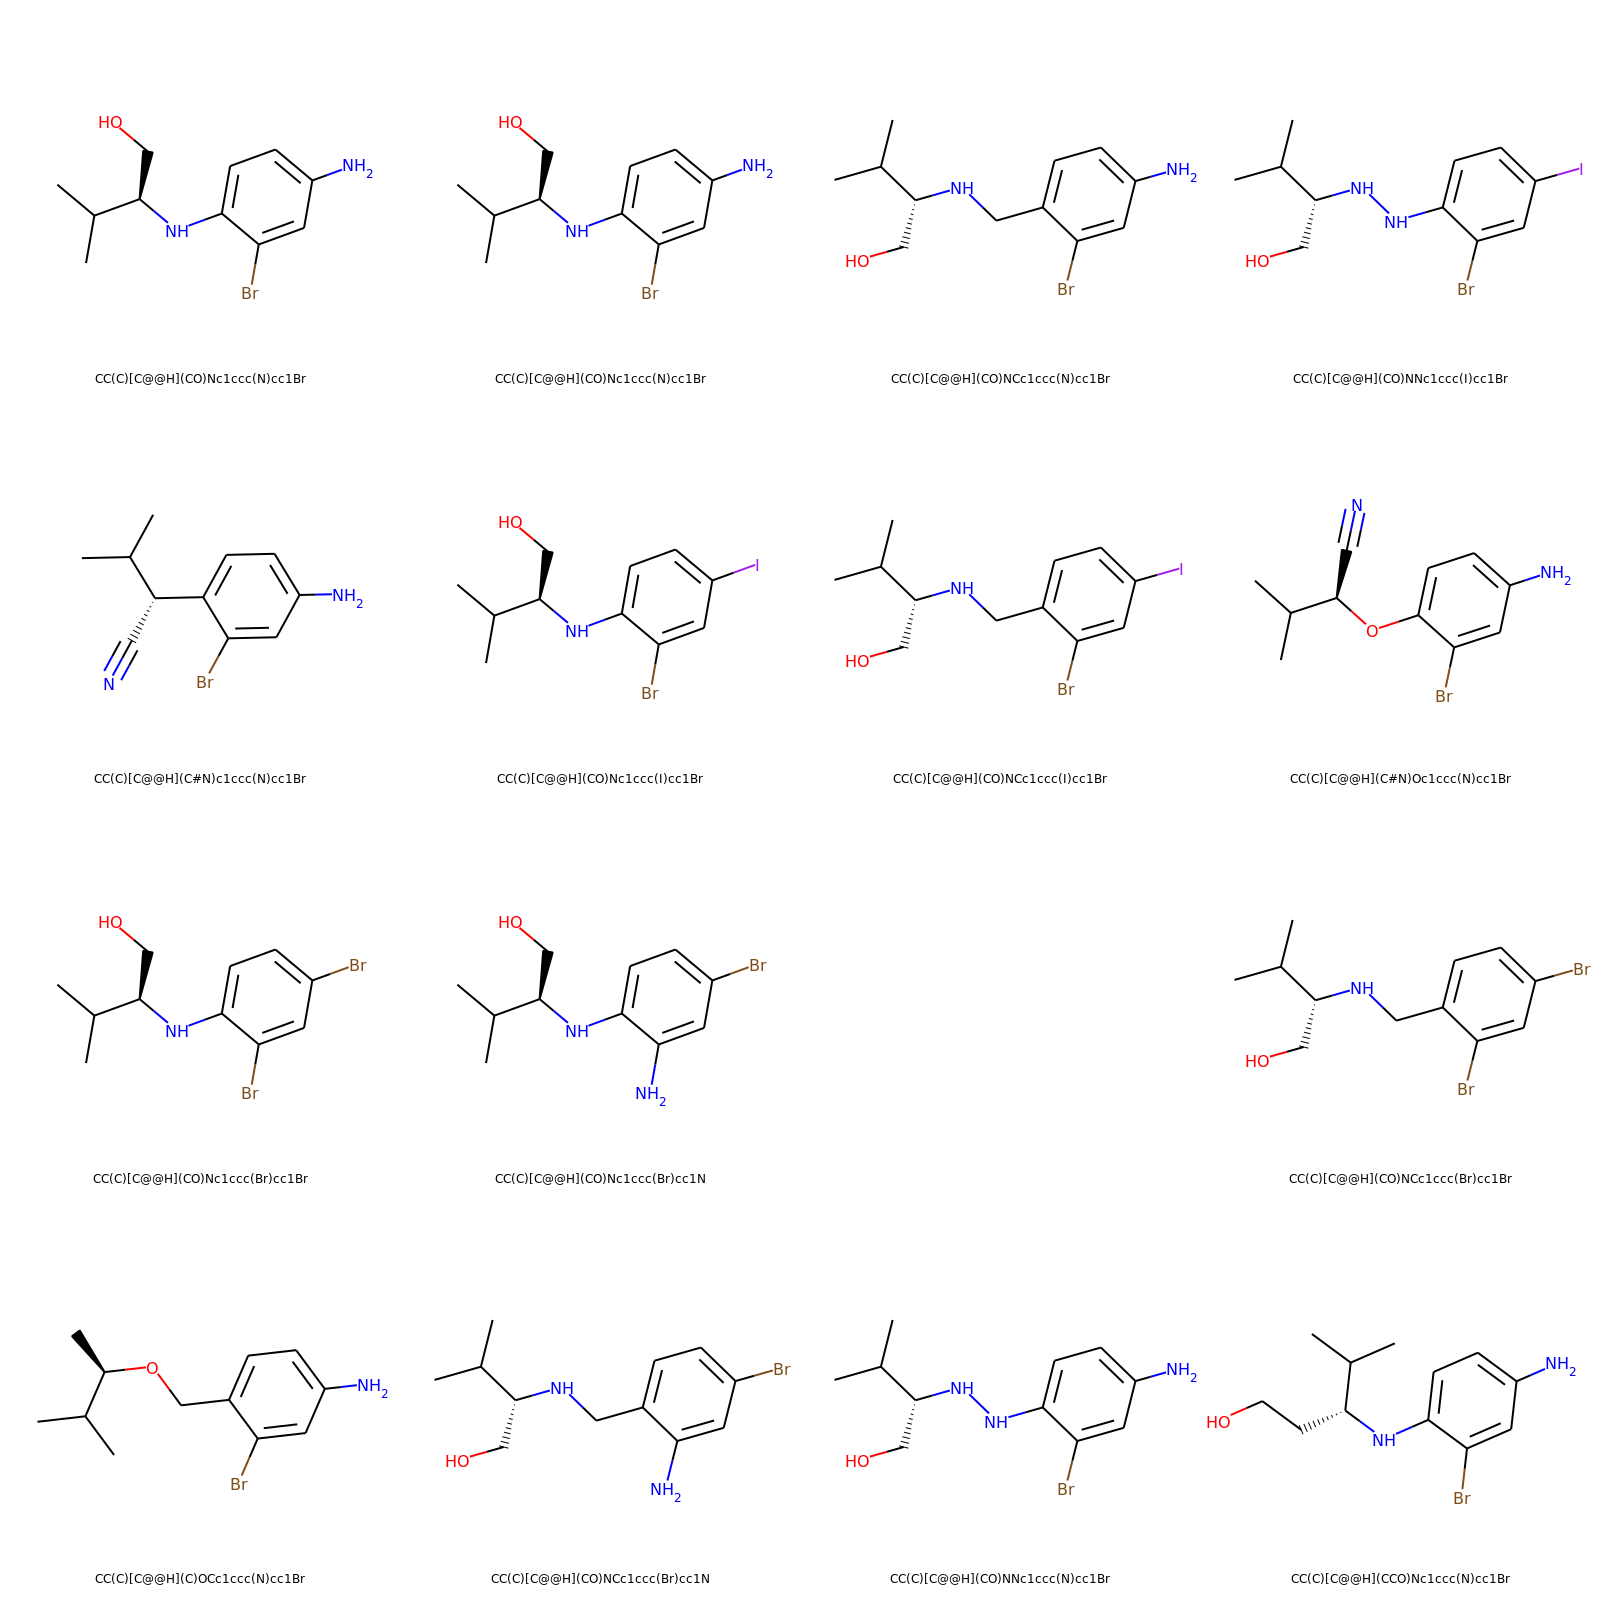

In [158]:
mean, _ = smiles2mean(configs, smile_x, model)
z, samples_idx, smiles_lst = latent2smiles(configs, model, mean, nsamples=15, sampling_mode='beam')

smiles_grid = [smile_x] + smiles_lst

mol_grid=[]
for smi in smiles_grid:
    try:
        mol_grid.append(Chem.MolFromSmiles(smi))
    except:
        pass

img=Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=4,subImgSize=(400,400), legends=smiles_grid)
img

### Greedy search at latent points sampled from conditional posterior distribution

In [159]:
nsamples = 24

In [160]:
mean, logv = smiles2mean(configs, smile_x, model)
std = torch.exp(0.5 * logv)
if configs['manifold_type'] == 'Euclidean':
    z = to_cuda_var(torch.randn([nsamples, configs['latent_size']]))
    z = z * std + mean
    vt = None
    u = None
elif configs['manifold_type'] == 'Lorentz':
    vt, u, z = lorentz_sampling(mean.repeat(nsamples,1), logv.repeat(nsamples,1))

In [161]:
samples_idx, z = model.inference(n=z.shape[0], sampling_mode='greedy', z=z)
smiles_x_samples = idx2smiles(configs, samples_idx)

In [162]:
smiles_x_samples_lst = [[smile_x, 0.0]]
for i in range(len(smiles_x_samples)):
    d2 = dist_z(configs['manifold_type'], mean.view(1,-1), z[i,:].view(1,-1))
    smiles_x_samples_lst.append([smiles_x_samples[i],d2.item()])
    
# sort by distance
smiles_x_samples_df = pd.DataFrame(smiles_x_samples_lst, columns=['SMILES','DISTANCE'])
smiles_x_samples_sorted = smiles_x_samples_df.sort_values(by=['DISTANCE']).SMILES.tolist()
smiles_x_distance_sorted = smiles_x_samples_df.sort_values(by=['DISTANCE']).DISTANCE.tolist()

# create legend
legend_lst = []
for l in range(len(smiles_x_samples_sorted)):
    legend = smiles_x_samples_sorted[l] + ' (' + str(round(smiles_x_distance_sorted[l],2)) + ')'
    legend_lst.append(legend)

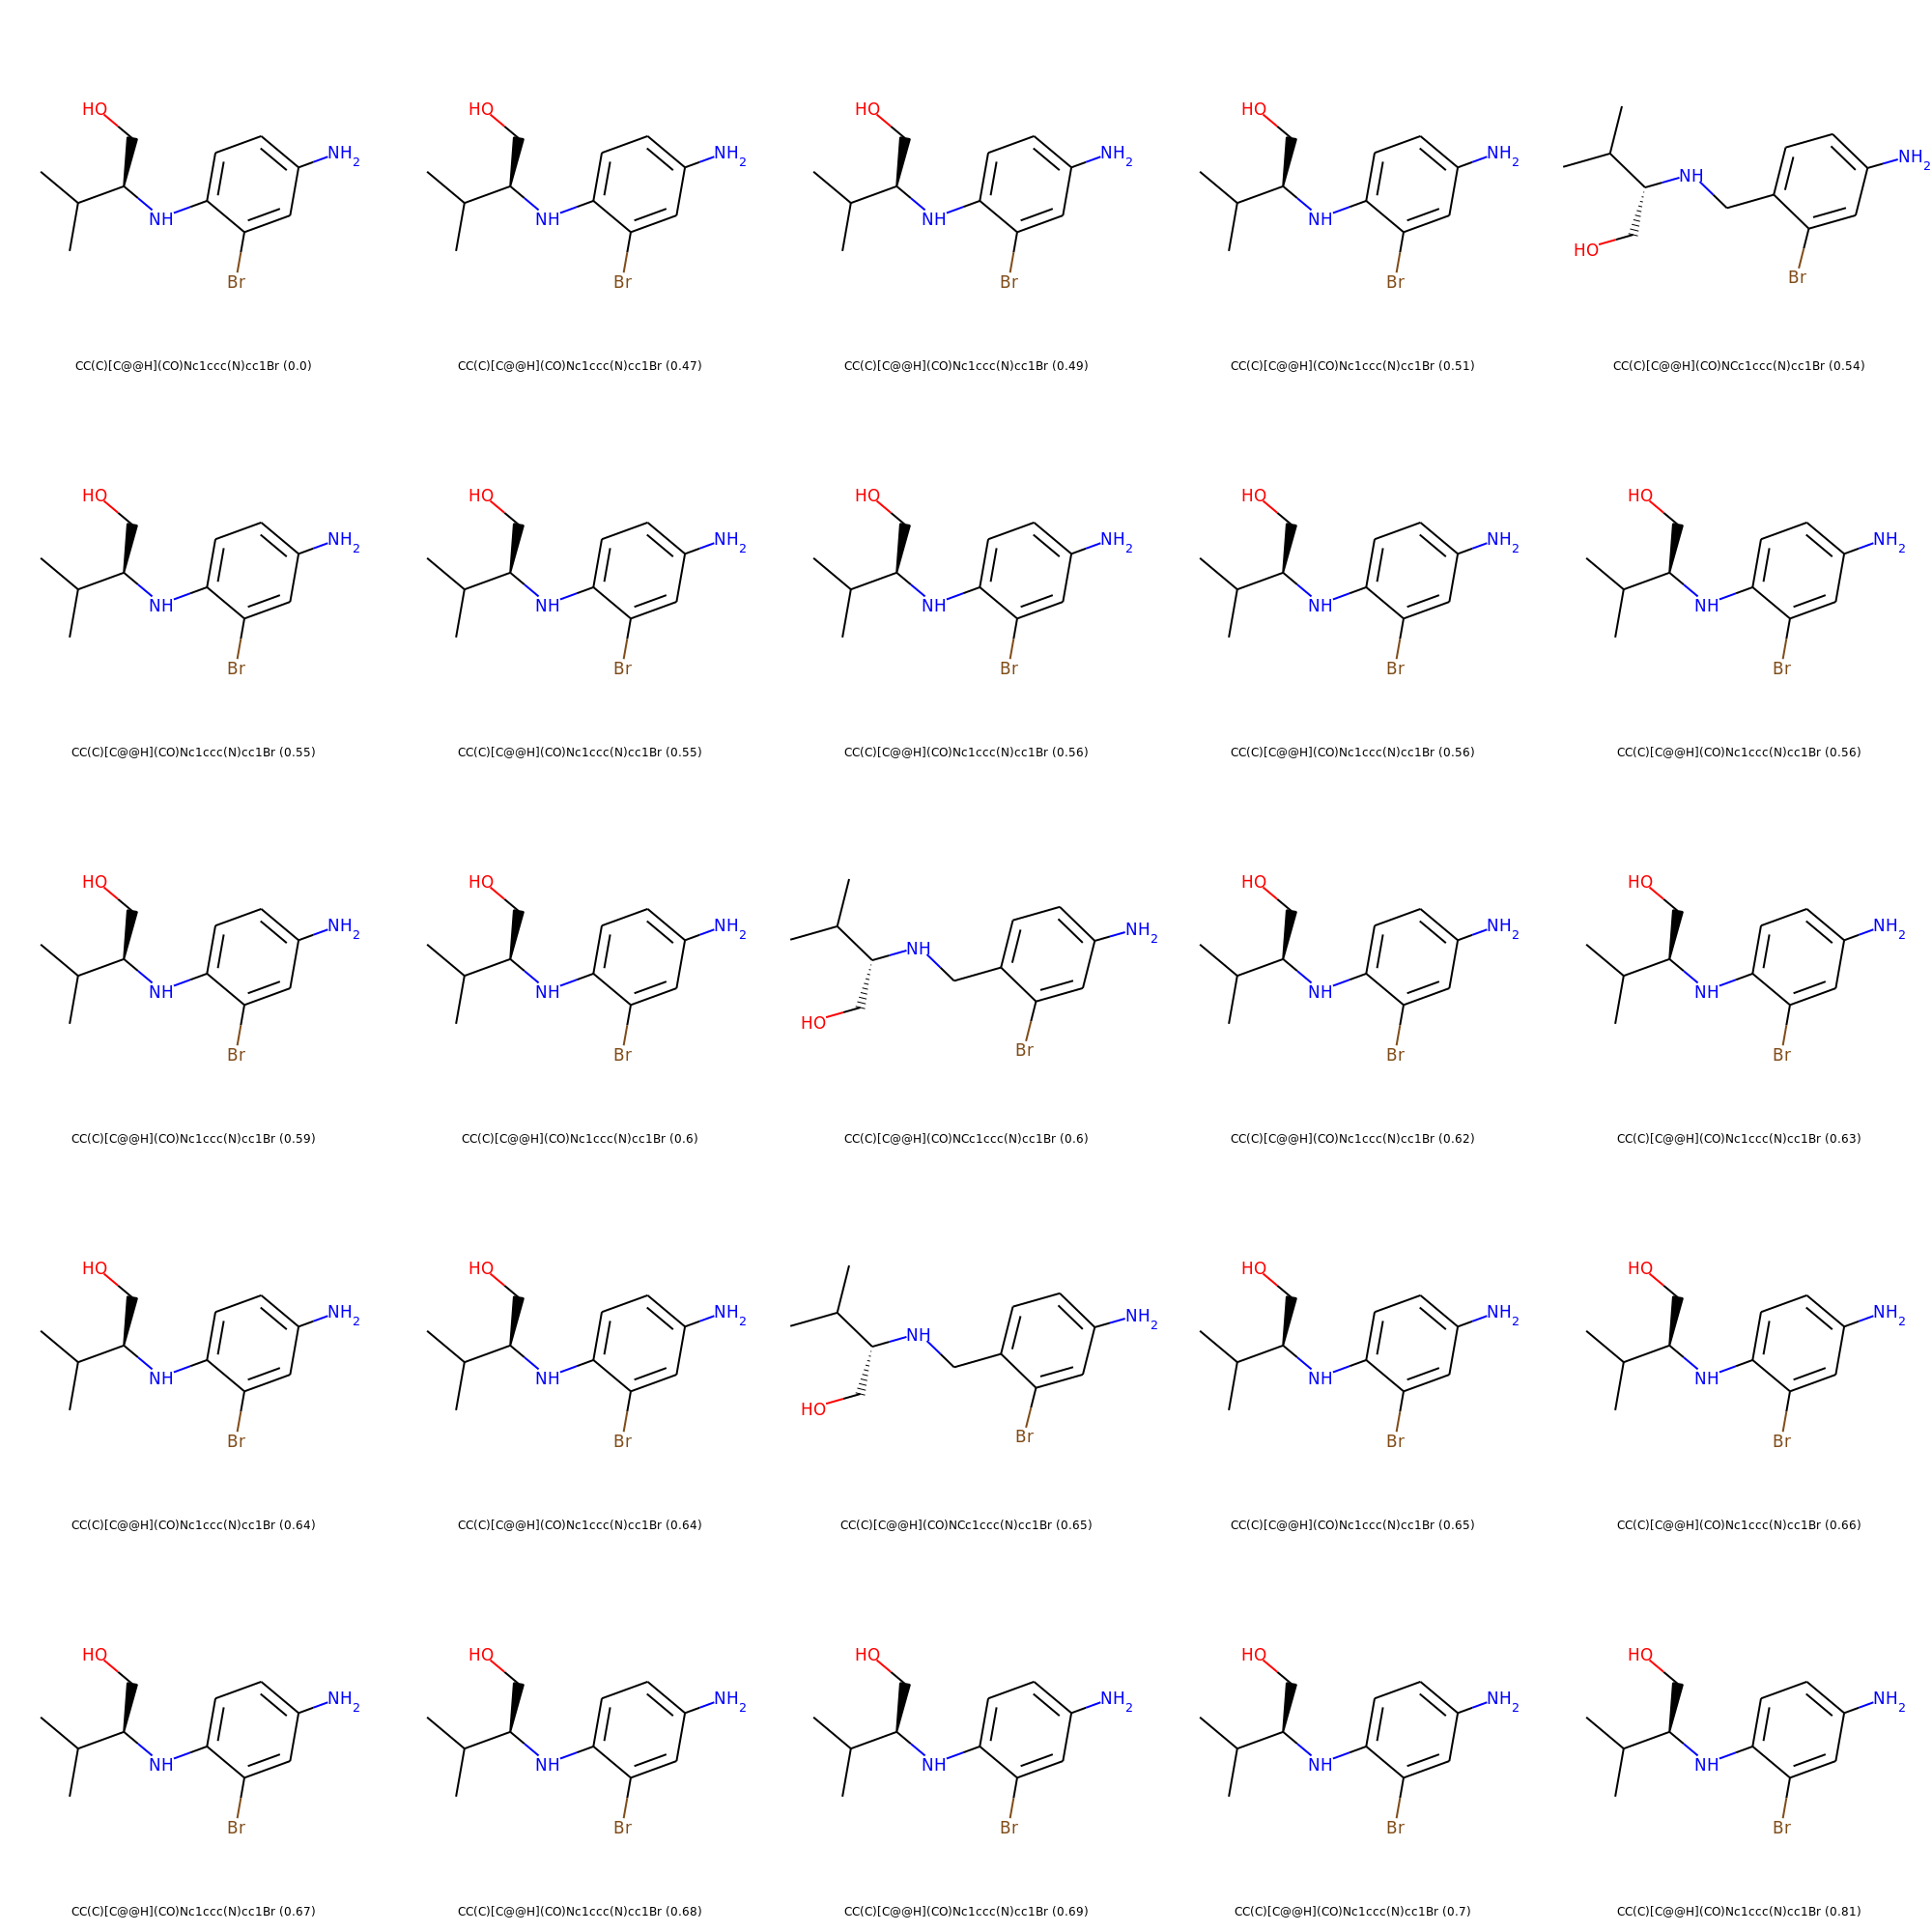

In [163]:
mol_grid=[]
smiles_grid = smiles_x_samples_sorted
for smi in smiles_grid:
    try:
        mol_grid.append(Chem.MolFromSmiles(smi))
    except:
        pass

Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=5,subImgSize=(400,400), legends=legend_lst)

### Greedy search in the region centered at the conditional mean point

In [164]:
nsamples = 100
noise_norm = 10

In [165]:
mean, _ = smiles2mean(configs, smile_x, model)
if torch.cuda.is_available():
    mean = mean.cpu()
mean = mean.detach().numpy()
mean = np.tile(mean, (nsamples, 1))
z = perturb_z(mean, noise_norm, constant_norm=False)
z = torch.from_numpy(z)
z = to_cuda_var(z).float()
mean = torch.from_numpy(mean)
mean = to_cuda_var(mean).float()

In [166]:
samples_idx, z = model.inference(n=z.shape[0], sampling_mode='greedy', z=z)
smiles_x_neighors = idx2smiles(configs, samples_idx)

In [167]:
smiles_x_neighors_lst = [[smile_x, 0.0]]
for i in range(len(smiles_x_neighors)):
    d2 = dist_z(configs['manifold_type'], mean[i,:].view(1,-1), z[i,:].view(1,-1))
    smiles_x_neighors_lst.append([smiles_x_neighors[i],d2.item()])

# sort by distance
smiles_x_neighors_df = pd.DataFrame(smiles_x_neighors_lst, columns=['SMILES','DISTANCE'])
# delete distance = Nan
smiles_x_neighors_df = smiles_x_neighors_df.dropna()

smiles_x_neighors_sorted = smiles_x_neighors_df.sort_values(by=['DISTANCE']).SMILES.tolist()
smiles_x_distance_sorted = smiles_x_neighors_df.sort_values(by=['DISTANCE']).DISTANCE.tolist()



# create legend
legend_lst = []
for l in range(len(smiles_x_neighors_sorted)):
    legend = smiles_x_neighors_sorted[l] + ' (' + str(round(smiles_x_distance_sorted[l],2)) + ')'
    legend_lst.append(legend)

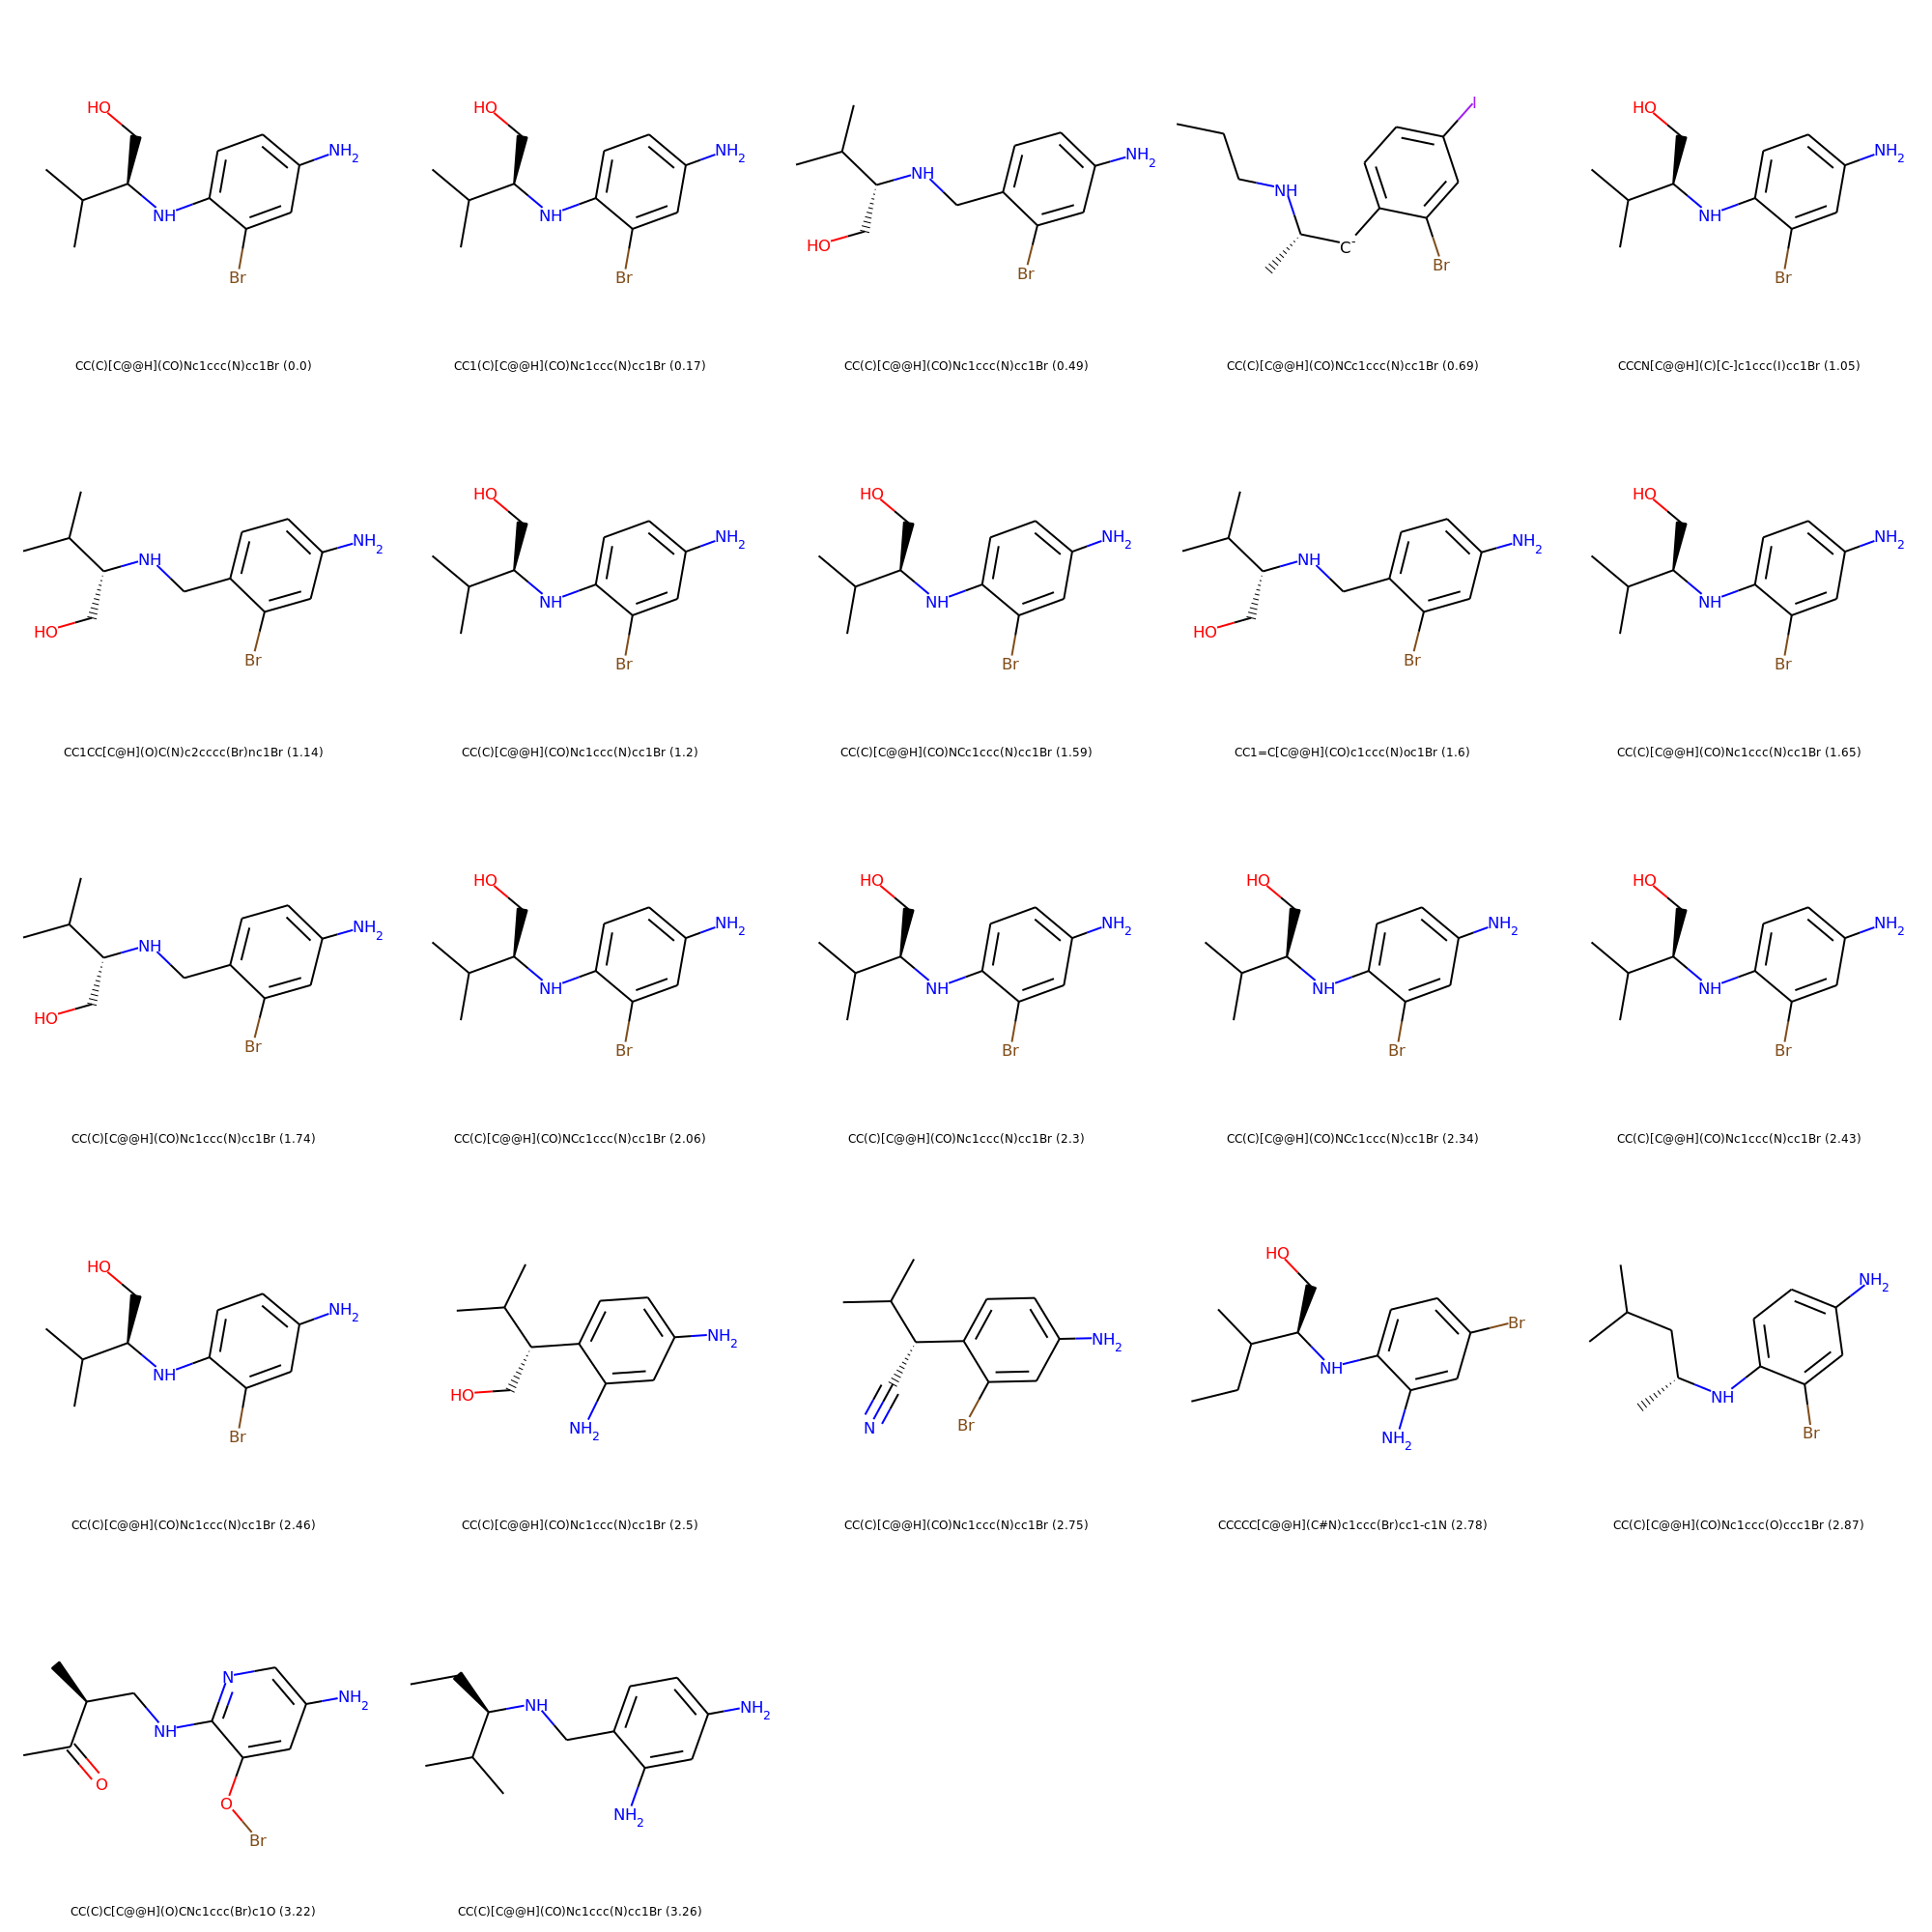

In [168]:
mol_grid=[]
smiles_grid = smiles_x_neighors_sorted
for smi in smiles_grid:
    try:
        mol_grid.append(Chem.MolFromSmiles(smi))
    except:
        pass

# remove invalid molecule from mol_grid
mol_grid = [m for m in mol_grid if m is not None]
Chem.Draw.MolsToGridImage(mol_grid,molsPerRow=5,subImgSize=(400,400), legends=legend_lst)

### Conditional reconstruction accuracy

In [177]:
# use FDA drugs dataset
smiles_fda = create_smiles_lst('./data', 'all_drugs_only.smi')
# set beam width to 5
B = 5 

In [178]:
recon_cnt = 0
posterior_smiles_lst = []
for smi in smiles_fda:
    # skip smiles that has characters not in the ZINC char list
    try:
        mu, logv = smiles2mean(configs, smi, model)
        _, _, posterior_smiles_sample = latent2smiles(configs,model, z=mu, nsamples=B, sampling_mode='beam')
        posterior_smiles_lst = posterior_smiles_lst + posterior_smiles_sample
        if smi in posterior_smiles_sample:
            recon_cnt+=1
    except:
        pass

In [179]:
print('%s%% SMILES in FDA drugs are reconstructed accurately.' %str(round(100*recon_cnt/len(smiles_fda),2)))

27.15% SMILES in FDA drugs are reconstructed accurately.


### Conditional validty

In [180]:
perc_valid, perc_chem_valid, _, _ = \
eval_prior_samples(configs, posterior_smiles_lst)

In [181]:
print('Using beam search (width = 5), %s%% sampled SMILES from conditional posterior distribution are valid.' %str(round((perc_valid*100),1)))

Using beam search (width = 5), 34.0% sampled SMILES from conditional posterior distribution are valid.


### Distribution of pairwise distances between 1K test molecules
#### Euclidean VAE

In [34]:
exp_name = 'exp_a_7'
num_mdls = 12
smiles_test = create_smiles_lst('./experiments/SMILES' + '/' + exp_name, 'smiles_test.smi')
input_smiles = random.sample(smiles_test,100)
dist_lst_euc, norm_euc = vae_pairwise_dist_hist(exp_name, num_mdls, input_smiles)

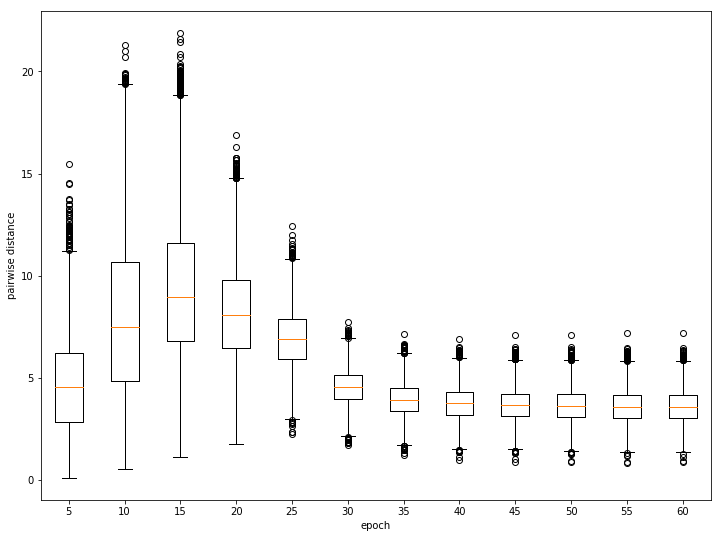

In [35]:
# Create a figure instance
fig = plt.figure(1, figsize=(12, 9))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(dist_lst_euc)

xlabels = []
for e in range(num_mdls):
    epoch = (e+1)*5
    xlabels.append(str(epoch))
ax.set_xticklabels(xlabels)
ax.set_xlabel('epoch')
ax.set_ylabel('pairwise distance')

fig.show()

### Distribution of embedding norms 1K test molecules
#### Euclidean VAE

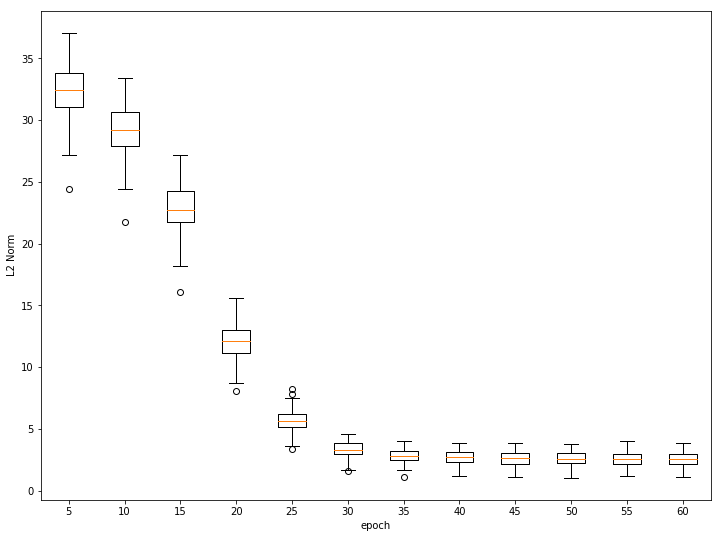

In [37]:
# Create a figure instance
fig = plt.figure(1, figsize=(12, 9))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(norm_euc)

xlabels = []
for e in range(num_mdls):
    epoch = (e+1)*5
    xlabels.append(str(epoch))
ax.set_xticklabels(xlabels)
ax.set_xlabel('epoch')
ax.set_ylabel('L2 Norm')

fig.show()

### Distribution of pairwise distances between 1K test molecules
#### Hyperbolic VAE

In [40]:
exp_name = 'exp_a_8'
num_mdls = 12
smiles_test = create_smiles_lst('./experiments/SMILES' + '/' + exp_name, 'smiles_test.smi')
input_smiles = random.sample(smiles_test,100)
dist_lst_lor, norm_poincare = vae_pairwise_dist_hist(exp_name, num_mdls, input_smiles)

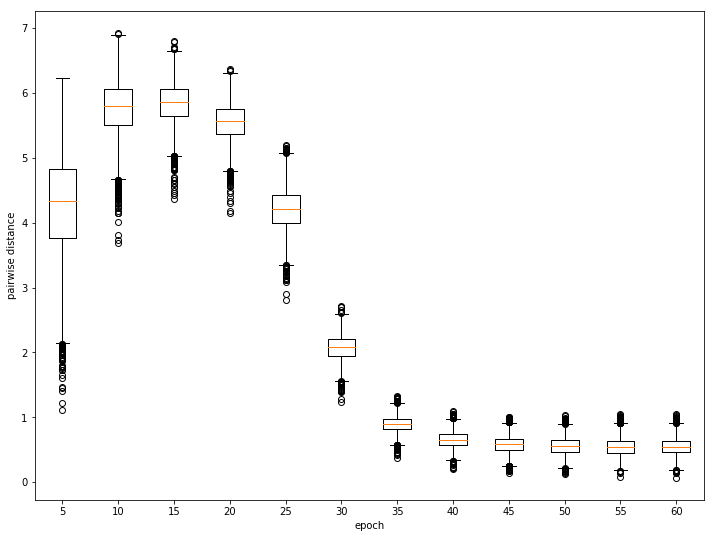

In [43]:
# Create a figure instance
fig = plt.figure(1, figsize=(12, 9))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(dist_lst_lor)
xlabels = []
for e in range(num_mdls):
    epoch = (e+1)*5
    xlabels.append(str(epoch))
ax.set_xticklabels(xlabels)
ax.set_xlabel('epoch')
ax.set_ylabel('pairwise distance')
fig.show()

### Distribution of embedding norms 1K test molecules
#### Hyperbolic VAE

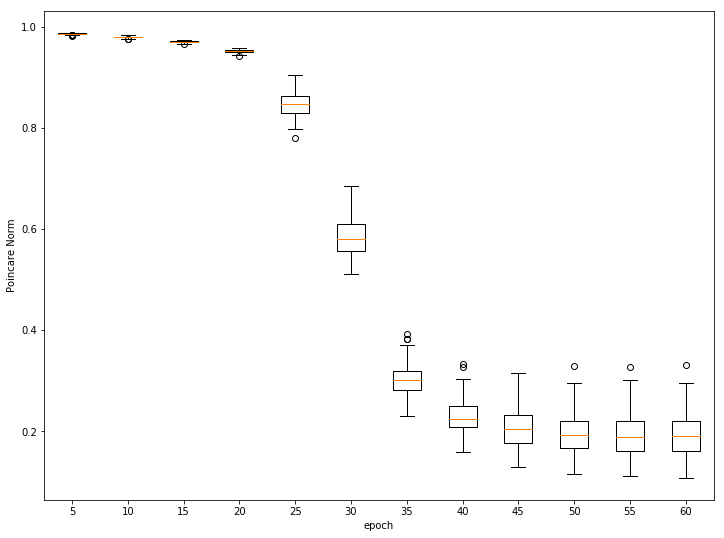

In [42]:
# Create a figure instance
fig = plt.figure(1, figsize=(12, 9))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(norm_poincare)
xlabels = []
for e in range(num_mdls):
    epoch = (e+1)*5
    xlabels.append(str(epoch))
ax.set_xticklabels(xlabels)
ax.set_xlabel('epoch')
ax.set_ylabel('Poincare Norm')
fig.show()

### Conditional reconstruction quality
* Tanimoto similarity: measures the similarity between moleculars' fingerprints
* Fingerprints: a way of encoding the structure of a moelcue. The most common type of fingerprint is a series of binary digits (bits) that represent the presence or absence of particular substructures in the molecule

#### Samples' Tanimoto similarity for a checkpoint

In [184]:
#define model
exp_name = 'exp_a_8'
checkpoint = 'checkpoint_epoch020.model'
exp_dir = './experiments/SMILES/'
config_path = os.path.join(exp_dir + exp_name, 'configs.json')
checkpoint_path = os.path.join(exp_dir + exp_name, checkpoint)

with open(config_path, 'r') as fp:
    configs = json.load(fp)
    fp.close()

try:
    configs['prior_var']
except:
    configs['prior_var'] = 1.0

# prepare train, valid, test datasets
datasets = OrderedDict()
splits = ['train', 'valid', 'test']
for split in splits:
    datasets[split] = textdata(directory=configs['data_dir'], split=split, vocab_file=configs['vocab_file'],
                               max_sequence_length=configs['max_sequence_length'])

#build model
model = MolVAE(
    vocab_size=datasets['train'].vocab_size,
    embedding_size=datasets['train'].vocab_size,
    hidden_size=configs['hidden_size'],
    latent_size=configs['latent_size'],
    manifold_type=configs['manifold_type'],
    rnn_type=configs['rnn_type'],
    bidirectional=configs['bidirectional'],
    num_layers=configs['num_layers'],
    word_dropout_rate=configs['word_dropout_rate'],
    embedding_dropout_rate=configs['embedding_dropout_rate'],
    one_hot_rep=configs['one_hot_rep'],
    max_sequence_length=configs['max_sequence_length'],
    sos_idx=datasets['train'].sos_idx,
    eos_idx=datasets['train'].eos_idx,
    pad_idx=datasets['train'].pad_idx,
    unk_idx=datasets['train'].unk_idx,
    prior_var=configs['prior_var']
)
# load checkpoint
model.load_state_dict(torch.load(checkpoint_path))
if torch.cuda.is_available():
    model = model.cuda()
model.eval()

MolVAE(
  (encoder_rnn): GRU(39, 500, batch_first=True)
  (decoder_rnn): GRU(39, 500, batch_first=True)
  (hidden2mean): Linear(in_features=500, out_features=40, bias=True)
  (hidden2logv): Linear(in_features=500, out_features=40, bias=True)
  (latent2hidden): Linear(in_features=41, out_features=500, bias=True)
  (outputs2vocab): Linear(in_features=500, out_features=39, bias=True)
)

In [185]:
smiles_test = create_smiles_lst('./experiments/SMILES' + '/' + exp_name, 'smiles_test.smi')
input_smiles = random.sample(smiles_test,100)
smiles_sample_lst = []
for smi in input_smiles:
    mean, logv = smiles2mean(configs, smi, model)
    samples_idx, z = model.inference(n=mean.shape[0], sampling_mode='greedy', z=mean)
    smi_sample = idx2smiles(configs, samples_idx)[0]
    # calculate target molecule metrics
    mol_t = smiles_to_mol(smi)
    fp_t = FingerprintMols.FingerprintMol(mol_t)
    # calculate sampled molecule metrics
    if smiles_to_mol(smi_sample) is not None:
        mol_s = smiles_to_mol(smi_sample)
        validty = 1
        fp_s = FingerprintMols.FingerprintMol(mol_s)
        tanimoto = DataStructs.FingerprintSimilarity(fp_t,fp_s)
    else:
        validty = 0
        fp_s = None
        tanimoto = 0
    smiles_sample_lst.append([smi, smi_sample, validty, smi==smi_sample, tanimoto])
smi_sample_df = pd.DataFrame(smiles_sample_lst,
                               columns=['SMILES_T', 'SMILES_S', 'VALIDITY', 'EXACT', 'TANIMOTO'])

In [186]:
smi_sample_df.head(20)

,SMILES_T,SMILES_S,VALIDITY,EXACT,TANIMOTO
0,CCOc1ccc([C@H]2[C@@H]3N=C4C=CC=C[C@H]4[C@@H]3C...,CCOc1ccc([C@H]2[C@@H]3N=C4=NCC[C@@H]4C3=[C@@H]...,0,False,0.000000
1,CN(C)c1ccc2c(c1)OCCN2C(=O)c1cc(Cl)ccc1[N+](=O)...,CN(C)c1ccc2c(c1)OCCN2C(=O)c1cc(Cl)ccc1[N+](=O)...,1,True,1.000000
2,COc1ccc(F)cc1NC(=O)N[C@H](Cc1ccccc1)C(=O)N1CCCC1,COc1ccc(F)cc1NC(=O)N[C@H](c1ccccc1)C(=O)N1CCCC1,1,False,0.639311
3,CC[C@@H](C)COC(=O)c1c(N)n(-c2cccc(F)c2)c2nc3cc...,CC[C@@H](C)COC(=O)c1c(N)n(-c2cccc(F)c2)c2nc3cc...,1,True,1.000000
4,Cc1cc(C)c(-c2c3ccccc3[n+](C)c3ccccc23)c(C)c1,Cc1cc(C)c(-c2cc3cccc([nH]3)Cc3ccccc3)c(C)c21,0,False,0.000000
5,Cc1ccc(NC(=O)c2ccc[n+]([O-])c2)cc1S(C)(=O)=O,Cc1ccc(NC(=O)c2ccc[n+]([O-])c2)cc1S(C)(=O)=O,1,True,1.000000
6,CN[C@@H](Cc1nc(-c2ccccc2)cs1)C(C)(C)[NH+](C)C,CN[C@@H](Cc1nc(-c2ccccc2)cc1)C(C)(C)[NH+](C)C,0,False,0.000000
7,CC(=O)Nc1ccc(S(=O)(=O)N2CCC[C@@H]([NH+]3CCOCC3...,CC(=O)Nc1ccc(S(=O)(=O)N2CCC[C@@H]([NH+]3CCOCC3...,1,True,1.000000
8,Cc1noc(C)c1[C@@H](C)CN[C@H](C)c1ccc(C(C)C)cc1,Cc1noc(C)c1[C@@H](C)NC[C@H](C)c1ccc(C(C)C)cc1,1,False,0.704433
9,O=C1OCCN1c1cccc2c1CC[NH+](Cc1cnn3c1NCCC3)C2,O=C1OCCNCc2ccccc2C1=C[NH+]1Cc2cnn3c(NCCC1)C2,0,False,0.000000


In [11]:
smi_sample_df.mean()

VALIDITY    0.0
EXACT       0.0
TANIMOTO    0.0
dtype: float64

#### Samples' Tanimoto similarity for a series of checkpoints

#### Hyperbolic

In [12]:
exp_name = 'exp_a_8'
smiles_test = create_smiles_lst('./experiments/SMILES' + '/' + exp_name, 'smiles_test.smi')
input_smiles = random.sample(smiles_test,100)
num_mdls = 12

validity_mean_lst_lor, exact_mean_lst_lor, tanimoto_mean_lst_lor = \
vae_conditional_samples_quality(exp_name, num_mdls, input_smiles)

#### Euclidean

In [13]:
exp_name = 'exp_a_7'
smiles_test = create_smiles_lst('./experiments/SMILES' + '/' + exp_name, 'smiles_test.smi')
input_smiles = random.sample(smiles_test,100)
num_mdls = 12

validity_mean_lst_euc, exact_mean_lst_euc, tanimoto_mean_lst_euc = \
vae_conditional_samples_quality(exp_name, num_mdls, input_smiles)

In [14]:
# prepare hv plots
epochs = list(np.arange(5,65,5))
val_lor = hv.Curve((epochs,validity_mean_lst_lor),label='Lorentz').opts(color='r')
val_euc = hv.Curve((epochs,validity_mean_lst_euc),label='Euclidean').opts(color='b')
exact_lor = hv.Curve((epochs,exact_mean_lst_lor),label='Lorentz').opts(color='r')
exact_euc = hv.Curve((epochs,exact_mean_lst_euc),label='Euclidean').opts(color='b')
tanimoto_lor = hv.Curve((epochs, tanimoto_mean_lst_lor),label='Lorentz').opts(color='r')
tanimoto_euc = hv.Curve((epochs, tanimoto_mean_lst_euc),label='Euclidean').opts(color='b')

#### conditional validity

In [15]:
sv = ((hv.Scatter(val_lor).opts(color='r')*val_lor) * (hv.Scatter(val_euc).opts(color='b')*val_euc)) \
.opts(xlabel='epoch', ylabel='validity')
sv

:Overlay
   .Scatter.Lorentz   :Scatter   [x]   (y)
   .Curve.Lorentz     :Curve   [x]   (y)
   .Scatter.Euclidean :Scatter   [x]   (y)
   .Curve.Euclidean   :Curve   [x]   (y)

#### conditional exact match

In [16]:
se = ((hv.Scatter(exact_lor).opts(color='r')*exact_lor) * (hv.Scatter(exact_euc).opts(color='b')*exact_euc)) \
.opts(xlabel='epoch', ylabel='%exact')
se

:Overlay
   .Scatter.Lorentz   :Scatter   [x]   (y)
   .Curve.Lorentz     :Curve   [x]   (y)
   .Scatter.Euclidean :Scatter   [x]   (y)
   .Curve.Euclidean   :Curve   [x]   (y)

#### conditional Tanimoto

In [17]:
((hv.Scatter(tanimoto_lor).opts(color='r')*tanimoto_lor) * (hv.Scatter(tanimoto_euc).opts(color='b')*tanimoto_euc)) \
.opts(xlabel='epoch', ylabel='%Tanimoto')

:Overlay
   .Scatter.Lorentz   :Scatter   [x]   (y)
   .Curve.Lorentz     :Curve   [x]   (y)
   .Scatter.Euclidean :Scatter   [x]   (y)
   .Curve.Euclidean   :Curve   [x]   (y)

### Process ATC file
* Anatomical Therapeutic Chemical (ATC) Classification Syste is a drug classification system that classifies the active ingredients of drugs according to organ or system on which they act.
* WHO page: https://www.whocc.no/atc/structure_and_principles/
* Datasource: https://bioportal.bioontology.org/ontologies/ATC
* ATC code lookup: https://www.whocc.no/atc_ddd_index/

In [54]:
df_atc = pd.read_csv('./data/ATC.csv', index_col=None)

In [55]:
df_atc.columns

Index(['Class ID', 'Preferred Label', 'Synonyms', 'Definitions', 'Obsolete',
       'CUI', 'Semantic Types', 'Parents', 'ATC LEVEL', 'Is Drug Class',
       'Semantic type UMLS property'],
      dtype='object')

In [104]:
# labels at each level
lvl5 = df_atc[df_atc['ATC LEVEL']==5]
lvl4 = df_atc[df_atc['ATC LEVEL']==4]
lvl3 = df_atc[df_atc['ATC LEVEL']==3]
lvl2 = df_atc[df_atc['ATC LEVEL']==2]
lvl1 = df_atc[df_atc['ATC LEVEL']==1]

In [119]:
# get parent-child relations at each level

lvl54_lst = []
for index, row in lvl5.iterrows():
    df = lvl4.loc[lvl4['Class ID']==row['Parents'], 'Preferred Label']
    lvl54_lst.append([row['Preferred Label'], df.values[0]])
lvl54_df = pd.DataFrame(lvl54_lst, columns = ['ATC_LVL5', 'ATC_LVL4'])

lvl43_lst = []
for index, row in lvl4.iterrows():
    df = lvl3.loc[lvl3['Class ID']==row['Parents'], 'Preferred Label']
    lvl43_lst.append([row['Preferred Label'], df.values[0]])
lvl43_df = pd.DataFrame(lvl43_lst, columns = ['ATC_LVL4', 'ATC_LVL3'])

lvl32_lst = []
for index, row in lvl3.iterrows():
    df = lvl2.loc[lvl2['Class ID']==row['Parents'], 'Preferred Label']
    lvl32_lst.append([row['Preferred Label'], df.values[0]])
lvl32_df = pd.DataFrame(lvl32_lst, columns = ['ATC_LVL3', 'ATC_LVL2'])

lvl21_lst = []
for index, row in lvl2.iterrows():
    df = lvl1.loc[lvl1['Class ID']==row['Parents'], 'Preferred Label']
    lvl21_lst.append([row['Preferred Label'], df.values[0]])
lvl21_df = pd.DataFrame(lvl21_lst, columns = ['ATC_LVL2', 'ATC_LVL1'])

In [120]:
# merge into master hierachical file
atc_543 = pd.merge(lvl54_df, lvl43_df, how='left', on='ATC_LVL4')
atc_5432 = pd.merge(atc_543, lvl32_df, how='left', on ='ATC_LVL3')
atc_54321 = pd.merge(atc_5432, lvl21_df, how='left', on ='ATC_LVL2')
atc = atc_54321.drop_duplicates()

In [ ]:
atc = atc.applymap(lower)

In [128]:
# save processed ATC hierarchy to file
atc.to_csv('./data/ATC_LOOKUP.csv', index=False)

#### ATC data summary

In [20]:
df_act = pd.read_csv('./data/ATC_LOOKUP.csv')

In [193]:
df_act.head(20)

,ATC_LVL5,ATC_LVL4,ATC_LVL3,ATC_LVL2,ATC_LVL1
0,silicones,other drugs for functional gastrointestinal di...,drugs for functional gastrointestinal disorders,drugs for functional gastrointestinal disorders,alimentary tract and metabolism drugs
1,cefatrizine,first-generation cephalosporins,other beta-lactam antibacterials in atc,antibacterials for systemic use,antiinfectives for systemic use
2,urofollitropin,gonadotropins,gonadotropins and other ovulation stimulants,sex hormones and modulators of the genital system,genito urinary system and sex hormones
3,promethazine,antihistamines for topical use,"antipruritics, incl. antihistamines, anestheti...","antipruritics, incl. antihistamines, anestheti...",dermatologicals
4,pinacidil and diuretics,other antihypertensives and diuretics in atc,antihypertensives and diuretics in combination,antihypertensives,cardiovascular system drugs
5,sargramostim,colony stimulating factors,immunostimulants,immunostimulants,antineoplastic and immunomodulating agents
6,cilostazol,platelet aggregation inhibitors excl. heparin,antithrombotic agents,antithrombotic agents,blood and blood forming organ drugs
7,"emepronium, combinations","hypnotics and sedatives in combination, excl. ...",hypnotics and sedatives,psycholeptics,nervous system drugs
8,androstanolone,androstan derivatives,anabolic steroids,anabolic agents for systemic use,alimentary tract and metabolism drugs
9,mefenorex,centrally acting antiobesity products,"antiobesity preparations, excl. diet products","antiobesity preparations, excl. diet products",alimentary tract and metabolism drugs


In [8]:
df_act.describe()

,ATC_LVL5,ATC_LVL4,ATC_LVL3,ATC_LVL2,ATC_LVL1
count,4905,4905,4905,4905,4905
unique,4239,785,243,90,14
top,betamethasone,other antineoplastic agents in atc,other antineoplastic agents in atc,antibacterials for systemic use,alimentary tract and metabolism drugs
freq,11,45,125,259,608


* One substance can be associated with multiple systems (ATC code)

In [22]:
df_lvl1_cnt = df_act.groupby(['ATC_LVL1'],as_index=False).count()

In [23]:
bars = hv.Bars(df_lvl1_cnt, hv.Dimension('ATC_LVL1'),'ATC_LVL5')
bars.opts(invert_axes=True, width=800)

:Bars   [ATC_LVL1]   (ATC_LVL5)

#### Comparison between FDA drugs and ATC substance

In [64]:
drugs_dict = {}
with open(fda_drugs_path, 'r') as file:
    for seq in file.readlines():
        if seq != '\n':
            line = seq.split(" ")
            drugs_dict[lower(line[1])] = line[0]
file.close()
fda_df = pd.DataFrame.from_dict(drugs_dict, orient='index').reset_index()
fda_df.columns = ['active_ingredient','smile_x']

#### Substance in both ATC and FDA

In [68]:
atc_fda_inner = pd.merge(df_act, fda_df, how='inner', left_on='ATC_LVL5', right_on='active_ingredient')

In [73]:
atc_fda_inner.head()

,ATC_LVL5,ATC_LVL4,ATC_LVL3,ATC_LVL2,ATC_LVL1,active_ingredient,smile_x
0,promethazine,antihistamines for topical use,"antipruritics, incl. antihistamines, anestheti...","antipruritics, incl. antihistamines, anestheti...",dermatologicals,promethazine,CC(CN1c2ccccc2Sc2ccccc21)N(C)C
1,promethazine,"phenothiazine derivatives, systemic antihistam...",antihistamines for systemic use,antihistamines for systemic use,respiratory system drugs,promethazine,CC(CN1c2ccccc2Sc2ccccc21)N(C)C
2,cilostazol,platelet aggregation inhibitors excl. heparin,antithrombotic agents,antithrombotic agents,blood and blood forming organ drugs,cilostazol,O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1
3,emtricitabine,nucleoside and nucleotide reverse transcriptas...,direct acting antivirals,antivirals for systemic use,antiinfectives for systemic use,emtricitabine,Nc1nc(=O)n([C@@H]2CS[C@H](CO)O2)cc1F
4,imiquimod,"antivirals, topical",chemotherapeutics for topical use,antibiotics and chemotherapeutics for dermatol...,dermatologicals,imiquimod,CC(C)Cn1cnc2c(N)nc3ccccc3c21


In [72]:
len(atc_fda_inner['active_ingredient'].unique())

1055

* 1355-1055 = 300 substances in FDA drugs but not in ATC
* 4239 - 1055 = 3184 ATC level 5 items not in FDA drugs dataset

In [74]:
# check FDA drugs that are not in ATC data
atc_fda_left = pd.merge(df_act, fda_df, how='left', left_on='ATC_LVL5', right_on='active_ingredient')

In [83]:
# looks like lots of ATC substances are not used in US
atc_fda_left[atc_fda_left['active_ingredient'].isnull()].ATC_LVL5.unique().tolist()

['silicones',
 'cefatrizine',
 'urofollitropin',
 'pinacidil and diuretics',
 'sargramostim',
 'emepronium, combinations',
 'androstanolone',
 'mefenorex',
 'aliskiren and amlodipine',
 'chloroform',
 'ciclonicate',
 'euflavine',
 'propyphenazone, combinations excl. psycholeptics',
 'succinylsulfathiazole',
 'hydrocortisone aceponate',
 'morphine, combinations',
 'flumetasone and antiinfectives',
 'levothyroxine sodium',
 'copper usnate',
 'hexamidine',
 'xenon (127xe) gas',
 'clobetasone',
 'emtricitabine, tenofovir disoproxil, elvitegravir and cobicistat',
 'ethulose',
 'pargyline and diuretics',
 'trospium and analgesics',
 'pyrrolnitrin',
 'axitinib',
 'cinepazet',
 'mipomersen',
 'cholera, combinations with typhoid vaccine, inactivated, whole cell',
 'bismuth subcitrate',
 'attapulgite, combinations',
 'trimethyldiphenylpropylamine',
 'multienzymes (lipase, protease etc.)',
 'norgestimate and ethinylestradiol',
 'temocillin',
 'iodine (131i) human albumin',
 'itramin tosilate',
 '

### FDA drugs embeddings at 2D space

#### Euclidean VAE

In [18]:
# Step 1: define model
exp_name = 'exp_a_7'
checkpoint = 'checkpoint_epoch060.model'
exp_dir = './experiments/SMILES/'
config_path = os.path.join(exp_dir + exp_name, 'configs.json')
checkpoint_path = os.path.join(exp_dir + exp_name, checkpoint)

with open(config_path, 'r') as fp:
    configs = json.load(fp)
    fp.close()

try:
    configs['prior_var']
except:
    configs['prior_var'] = 1.0

# prepare train, valid, test datasets
datasets = OrderedDict()
splits = ['train', 'valid', 'test']
for split in splits:
    datasets[split] = textdata(directory=configs['data_dir'], split=split, vocab_file=configs['vocab_file'],
                               max_sequence_length=configs['max_sequence_length'])

#build model
model = MolVAE(
    vocab_size=datasets['train'].vocab_size,
    embedding_size=datasets['train'].vocab_size,
    hidden_size=configs['hidden_size'],
    latent_size=configs['latent_size'],
    manifold_type=configs['manifold_type'],
    rnn_type=configs['rnn_type'],
    bidirectional=configs['bidirectional'],
    num_layers=configs['num_layers'],
    word_dropout_rate=configs['word_dropout_rate'],
    embedding_dropout_rate=configs['embedding_dropout_rate'],
    one_hot_rep=configs['one_hot_rep'],
    max_sequence_length=configs['max_sequence_length'],
    sos_idx=datasets['train'].sos_idx,
    eos_idx=datasets['train'].eos_idx,
    pad_idx=datasets['train'].pad_idx,
    unk_idx=datasets['train'].unk_idx,
    prior_var=configs['prior_var']
)
# load checkpoint
model.load_state_dict(torch.load(checkpoint_path))
if torch.cuda.is_available():
    model = model.cuda()
model.eval()

MolVAE(
  (encoder_rnn): GRU(39, 500, batch_first=True)
  (decoder_rnn): GRU(39, 500, batch_first=True)
  (hidden2mean): Linear(in_features=500, out_features=40, bias=True)
  (hidden2logv): Linear(in_features=500, out_features=40, bias=True)
  (latent2hidden): Linear(in_features=40, out_features=500, bias=True)
  (outputs2vocab): Linear(in_features=500, out_features=39, bias=True)
)

In [19]:
# step 2: compute the posterior means for FDA drugs
fda_drugs = 'all_drugs.smi'
fda_drugs_path = os.path.join('./data/', fda_drugs)

w2i, i2w = idx2word(configs['data_dir'], configs['vocab_file'])

In [20]:
drugs_dict = {}
with open(fda_drugs_path, 'r') as file:
    for seq in file.readlines():
        if seq != '\n':
            line = seq.split(" ")
            drugs_dict[line[1]] = line[0]
file.close()

In [21]:
drugs_mu_dict = {}
for key in drugs_dict.keys():
    smile_1st = drugs_dict[key]
    input_sequence = [w2i['<sos>']]
    for i in smile_1st:
        try:
            input_sequence.append(w2i[i])
        except:
            input_sequence.append(w2i['<unk>'])
    input_sequence.append(w2i['<eos>'])
    input_sequence = input_sequence + [0] * (configs['max_sequence_length'] - len(input_sequence) - 1)
    input_sequence = np.asarray(input_sequence)
    input_sequence = torch.from_numpy(input_sequence).unsqueeze(0)
    sequence_length = torch.tensor([len(smile_1st) + 1])
    _, mean, logv, _, _, _ = model.forward(input_sequence, sequence_length)

    samples_idx, z = model.inference(n=1, sampling_mode='greedy', z=mean)
    for i in range(1):
        smiles = []
        for j in range(configs['max_sequence_length']):
            if samples_idx[i, j] == w2i['<eos>']:
                break
            smiles.append(i2w[samples_idx[i, j].item()])
        smiles = "".join(smiles)

    drugs_mu_dict[key] = [smile_1st, smiles, mean.cpu().detach().numpy()]

In [22]:
# Combine drugs latent representations into a matrix
drug_lst=[]
smile_lst=[]
gen_smile_lst=[]
latent_lst=[]
label_lst=[]
for key in drugs_mu_dict.keys():
    h = drugs_mu_dict[key][2]
    latent_lst.append(h)
    drug_lst.append(key)
    smile_lst.append(drugs_mu_dict[key][0])
    gen_smile_lst.append(drugs_mu_dict[key][1])
    label_lst.append(key+'<br>'+drugs_mu_dict[key][0]+'<br>'+drugs_mu_dict[key][1])
latent_reps = np.asarray(latent_lst).squeeze()

In [23]:
latent_reps.shape

(1365, 40)

#### UMap
Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data

* The data is uniformly distributed on Riemannian manifold;
* The Riemannian metric is locally constant (or can be approximated as such);
* The manifold is locally connected.

In [24]:
# step 3: reduce dimension using UMap
reducer = umap.UMAP()
embedding = reducer.fit_transform(latent_reps)
embedding.shape

(1365, 2)

In [25]:
df_act = pd.read_csv('./data/ATC_LOOKUP.csv')

In [26]:
# remove drugs associated with multiple parents
df_count = df_act.groupby('ATC_LVL5',as_index=False).count()
df_temp = df_count[df_count['ATC_LVL4']==1]['ATC_LVL5']
df_act_clean = pd.merge(df_act,df_temp, how='inner',on='ATC_LVL5')

In [27]:
# Step 4: create a dataframe for visualization
fda_embedding_lst = []
idx = 0
for k in drugs_mu_dict.keys():
    key = k.lower()
    x1 = embedding[idx,0]
    x2 = embedding[idx,1]
    smile_x = drugs_mu_dict[k][0]
    smile_g = drugs_mu_dict[k][1]
    fda_embedding_lst.append([key, x1, x2, smile_x, smile_g])
    idx += 1
fda_embedding_df = pd.DataFrame(fda_embedding_lst, columns=['active_ingredient','x1','x2','smile_x','smile_g'])

In [28]:
fda_embedding_act_euc_df = pd.merge(fda_embedding_df, df_act_clean, how='left', \
                                left_on='active_ingredient', right_on='ATC_LVL5')

In [29]:
fda_embedding_act_euc_df.head(10)

,active_ingredient,x1,x2,smile_x,smile_g,ATC_LVL5,ATC_LVL4,ATC_LVL3,ATC_LVL2,ATC_LVL1
0,abacavir,1.719311,1.123242,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,Cc1cc(C(=O)Nc2ccc(N3CC[NH+](C)CC3)[nH+]c2)no1,abacavir,nucleoside and nucleotide reverse transcriptas...,direct acting antivirals,antivirals for systemic use,antiinfectives for systemic use
1,abiraterone,-5.745691,0.153213,CC(=O)O[C@H]1CC[C@@]2(C)C(=CCC3C4CC=C(c5cccnc5...,CC(=O)N[C@H]1[C@H]2CC[C@H](C1)N(C(=O)c1ccc(N3C...,abiraterone,other hormone antagonists and related agents i...,hormone antagonists and related agents,endocrine therapy antineoplastic and immunomod...,antineoplastic and immunomodulating agents
2,acamprosate,4.850507,-2.099449,CC(=O)NCCCS(=O)(=O)O,CC(=O)NCCNC(=O)CCCCC1,acamprosate,drugs used in alcohol dependence,drugs used in addictive disorders,other nervous system drugs in atc,nervous system drugs
3,acebutolol,1.836667,-1.840663,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1,CCCNC(=O)c1ccc(C(=O)NCC(=O)NC(C)(C)C)cc1,acebutolol,"beta blocking agents, selective",beta blocking agents,beta-adrenergic blocking agents,cardiovascular system drugs
4,acenocoumarol,0.324164,-3.067299,CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2...,CC(=O)Nc1ccc(NC(=O)C(=O)NCCc2ccc3c(c2)OCO3)cc1,acenocoumarol,vitamin k antagonists,antithrombotic agents,antithrombotic agents,blood and blood forming organ drugs
5,acepromazine,0.692303,-1.758414,CC(=O)c1ccc2c(c1)N(CCCN(C)C)c1ccccc1S2,CC(=O)c1cccc(NC(=O)c2ccc(Cl)cc2Cl)c1,acepromazine,"phenothiazines with aliphatic side-chain, anti...",antipsychotics,psycholeptics,nervous system drugs
6,aceprometazine,0.685611,-1.751779,CC(=O)c1ccc2c(c1)N(CC(C)N(C)C)c1ccccc1S2,CC(=O)c1cccc(NC(=O)c2ccc(C(=O)NC)cc2)c1,NaN,NaN,NaN,NaN,NaN
7,acetaminophen,3.342360,-3.188015,CC(=O)Nc1ccc(O)cc1,CC(=O)Nc1ccc(Br)cc1,NaN,NaN,NaN,NaN,NaN
8,acetazolamide,3.017187,-2.821718,CC(=O)Nc1nnc(S(N)(=O)=O)s1,CC(=O)Nc1ccc(C(=O)NC2CC2)cc1,acetazolamide,"carbonic anhydrase inhibitors, antiglaucoma dr...",antiglaucoma preparations and miotics,ophthalmologicals,sensory organ drugs
9,acetic,4.026502,-1.858378,CC(=O)[O-],C[NH+]1CCC[C@H]1CNC(=O)CCCCCC1,NaN,NaN,NaN,NaN,NaN


#### Remove drugs:
* Don't have a ATC mapping
* Associated with multiple ATC parents

In [30]:
scatter_df_euc = fda_embedding_act_euc_df[fda_embedding_act_euc_df['ATC_LVL5'].isnull()==False]

In [31]:
scatter_df_euc.shape

(891, 10)

In [195]:
scatter = hv.Scatter(scatter_df_euc, 'x1',vdims=['x2','ATC_LVL1','active_ingredient','smile_x','smile_g'])
scatter.opts(width=900,height=600,size=5,color='ATC_LVL1',show_legend=False,cmap='tab20')

:Scatter   [x1]   (x2,ATC_LVL1,active_ingredient,smile_x,smile_g)

#### Hyperbolic VAE

In [33]:
# Step 1: define model
exp_name = 'exp_a_8'
checkpoint = 'checkpoint_epoch020.model'
exp_dir = './experiments/SMILES/'
config_path = os.path.join(exp_dir + exp_name, 'configs.json')
checkpoint_path = os.path.join(exp_dir + exp_name, checkpoint)

with open(config_path, 'r') as fp:
    configs = json.load(fp)
    fp.close()

try:
    configs['prior_var']
except:
    configs['prior_var'] = 1.0

# prepare train, valid, test datasets
datasets = OrderedDict()
splits = ['train', 'valid', 'test']
for split in splits:
    datasets[split] = textdata(directory=configs['data_dir'], split=split, vocab_file=configs['vocab_file'],
                               max_sequence_length=configs['max_sequence_length'])

#build model
model = MolVAE(
    vocab_size=datasets['train'].vocab_size,
    embedding_size=datasets['train'].vocab_size,
    hidden_size=configs['hidden_size'],
    latent_size=configs['latent_size'],
    manifold_type=configs['manifold_type'],
    rnn_type=configs['rnn_type'],
    bidirectional=configs['bidirectional'],
    num_layers=configs['num_layers'],
    word_dropout_rate=configs['word_dropout_rate'],
    embedding_dropout_rate=configs['embedding_dropout_rate'],
    one_hot_rep=configs['one_hot_rep'],
    max_sequence_length=configs['max_sequence_length'],
    sos_idx=datasets['train'].sos_idx,
    eos_idx=datasets['train'].eos_idx,
    pad_idx=datasets['train'].pad_idx,
    unk_idx=datasets['train'].unk_idx,
    prior_var=configs['prior_var']
)
# load checkpoint
model.load_state_dict(torch.load(checkpoint_path))
if torch.cuda.is_available():
    model = model.cuda()
model.eval()

MolVAE(
  (encoder_rnn): GRU(39, 500, batch_first=True)
  (decoder_rnn): GRU(39, 500, batch_first=True)
  (hidden2mean): Linear(in_features=500, out_features=40, bias=True)
  (hidden2logv): Linear(in_features=500, out_features=40, bias=True)
  (latent2hidden): Linear(in_features=41, out_features=500, bias=True)
  (outputs2vocab): Linear(in_features=500, out_features=39, bias=True)
)

In [34]:
# step 2: compute the posterior means for FDA drugs
fda_drugs = 'all_drugs.smi'
fda_drugs_path = os.path.join('./data/', fda_drugs)

w2i, i2w = idx2word(configs['data_dir'], configs['vocab_file'])

In [35]:
drugs_dict = {}
with open(fda_drugs_path, 'r') as file:
    for seq in file.readlines():
        if seq != '\n':
            line = seq.split(" ")
            drugs_dict[line[1]] = line[0]
file.close()

In [36]:
drugs_mu_dict = {}
for key in drugs_dict.keys():
    smile_1st = drugs_dict[key]
    input_sequence = [w2i['<sos>']]
    for i in smile_1st:
        try:
            input_sequence.append(w2i[i])
        except:
            input_sequence.append(w2i['<unk>'])
    input_sequence.append(w2i['<eos>'])
    input_sequence = input_sequence + [0] * (configs['max_sequence_length'] - len(input_sequence) - 1)
    input_sequence = np.asarray(input_sequence)
    input_sequence = torch.from_numpy(input_sequence).unsqueeze(0)
    sequence_length = torch.tensor([len(smile_1st) + 1])
    _, mean, logv, _, _, _ = model.forward(input_sequence, sequence_length)

    samples_idx, z = model.inference(n=1, sampling_mode='greedy', z=mean)
    for i in range(1):
        smiles = []
        for j in range(configs['max_sequence_length']):
            if samples_idx[i, j] == w2i['<eos>']:
                break
            smiles.append(i2w[samples_idx[i, j].item()])
        smiles = "".join(smiles)

    drugs_mu_dict[key] = [smile_1st, smiles, mean.cpu().detach().numpy()]

In [37]:
drugs_mu_dict['Ibuprofen']

['CC(C)Cc1ccc(C(C)C(=O)O)cc1',
 'CC(C)Cc1ccc(C(C)C)(=O)cc1',
 array([[22.009996  ,  4.2600303 , -1.0377649 , -4.612673  ,  3.509456  ,
          1.6311148 ,  3.1235855 , -1.5334178 , -0.52247727, -8.560412  ,
         -2.9568646 , -0.6265015 ,  1.3404174 ,  0.44354567,  2.9884005 ,
          6.7653522 ,  6.894852  , -4.355348  , -3.8179023 ,  5.10375   ,
         -1.9362819 , -0.45652473, -7.2309484 ,  3.6547368 , -2.457532  ,
         -3.745994  ,  1.8745759 , -0.836447  ,  0.24777047, -1.8397822 ,
         -0.25324205, -5.1035786 , -4.6708593 , -0.20485628, -1.0075821 ,
         -4.240817  ,  0.72173   , -1.4156878 , -0.8270999 ,  1.134951  ,
         -0.7334209 ]], dtype=float32)]

In [38]:
# Combine drugs latent representations into a matrix
drug_lst=[]
smile_lst=[]
gen_smile_lst=[]
latent_lst=[]
label_lst=[]
for key in drugs_mu_dict.keys():
    h = drugs_mu_dict[key][2]
    latent_lst.append(h)
    drug_lst.append(key)
    smile_lst.append(drugs_mu_dict[key][0])
    gen_smile_lst.append(drugs_mu_dict[key][1])
    label_lst.append(key+'<br>'+drugs_mu_dict[key][0]+'<br>'+drugs_mu_dict[key][1])
latent_lor_reps = np.asarray(latent_lst).squeeze()

In [39]:
latent_lor_reps.shape

(1365, 41)

#### UMap
Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data

* The data is uniformly distributed on Riemannian manifold;
* The Riemannian metric is locally constant (or can be approximated as such);
* The manifold is locally connected.

In [40]:
# convert to Poincare ball
latent_poi_reps = lorentz_to_poincare(latent_lor_reps)

In [41]:
latent_poi_reps.shape

(1365, 40)

In [42]:
# step 3: reduce dimension using UMap
reducer = umap.UMAP()
embedding = reducer.fit_transform(latent_poi_reps)
embedding.shape

(1365, 2)

In [43]:
# Step 4: create a dataframe for visualization
fda_embedding_lst = []
idx = 0
for k in drugs_mu_dict.keys():
    key = k.lower()
    x1 = embedding[idx,0]
    x2 = embedding[idx,1]
    smile_x = drugs_mu_dict[k][0]
    smile_g = drugs_mu_dict[k][1]
    fda_embedding_lst.append([key, x1, x2, smile_x, smile_g])
    idx += 1
fda_embedding_df = pd.DataFrame(fda_embedding_lst, columns=['active_ingredient','x1','x2','smile_x','smile_g'])

In [44]:
fda_embedding_act_lor_df = pd.merge(fda_embedding_df, df_act_clean, how='left', \
                                left_on='active_ingredient', right_on='ATC_LVL5')

#### Remove drugs:
* Don't have a ATC mapping
* Associated with multiple ATC parents

In [45]:
scatter_df_lor = fda_embedding_act_lor_df[fda_embedding_act_lor_df['ATC_LVL5'].isnull()==False]
scatter_df_lor.shape

(891, 10)

In [46]:
scatter = hv.Scatter(scatter_df_lor, 'x1',vdims=['x2','ATC_LVL1','active_ingredient','smile_x','smile_g'])
scatter.opts(width=900, height=600, size=5,color='ATC_LVL1',show_legend=False,cmap='tab20')

:Scatter   [x1]   (x2,ATC_LVL1,active_ingredient,smile_x,smile_g)

* drugs with common sub-SMILES tend to cluster together
* drugs belong to the same system (e.g. alimentary tract and metabolism (red dots))) could have very different molecular structures and thus locate at very differet regions in the latent space

## Hierarchical clustering for FDA drugs using latent coordinates

In [48]:
nsamples, _ = latent_lor_reps.shape

In [49]:
lor_dist_condensed = pairwise_dist('Lorentz',latent_lor_reps)

In [50]:
lor_dist_mtrx = spatial.distance.squareform(lor_dist_condensed)

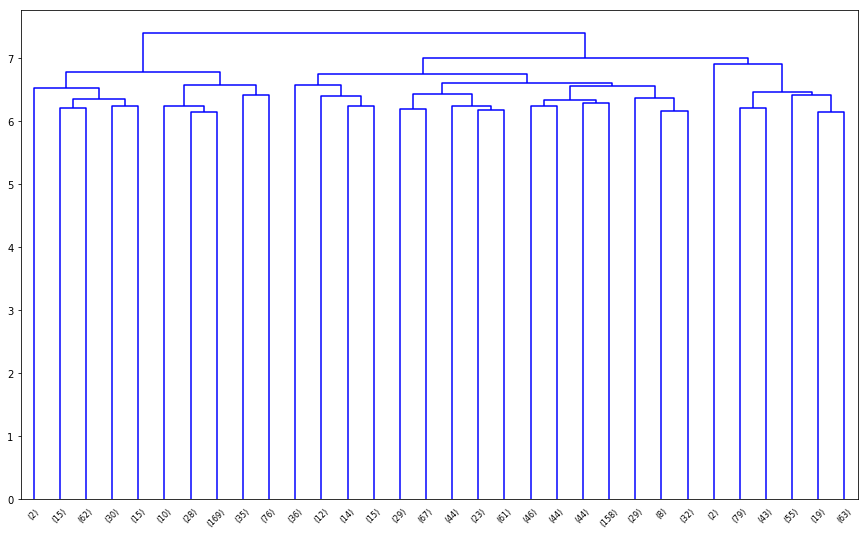

In [51]:
figure = plt.figure(figsize=(15,9))
linkage_lor = linkage(lor_dist_condensed, 'complete')
den_lor = dendrogram(linkage_lor, truncate_mode='lastp', p=32)

#### A (n-1) by 4 matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n+i . A cluster with an index less than n corresponds to one of the n original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster

In [52]:
linkage_lor.shape

(1364, 4)

In [53]:
linkage_lor

array([[6.10000000e+01, 1.24900000e+03, 1.10483319e-02, 2.00000000e+00],
       [1.15400000e+03, 1.31800000e+03, 1.35312760e-02, 2.00000000e+00],
       [3.94000000e+02, 4.68000000e+02, 4.36935961e-01, 2.00000000e+00],
       ...,
       [2.15400000e+03, 2.71800000e+03, 6.90583372e+00, 2.61000000e+02],
       [2.72400000e+03, 2.72600000e+03, 7.00016308e+00, 9.23000000e+02],
       [2.72500000e+03, 2.72700000e+03, 7.39439487e+00, 1.36500000e+03]])

In [66]:
linkage_lor[:,0].min()

0.0

In [67]:
fda_drugs_names = list(drugs_mu_dict.keys())

In [98]:
# decoding linkage output
niterations, _ = linkage_lor.shape
linkage_lor_decoded = {}
for i in range(niterations):
    iteration = linkage_lor[i]
    
    i1 = int(iteration[0])
    i2 = int(iteration[1])
    
    if i1 < nsamples:
        c1 = [fda_drugs_names[i1]]
    else:
        c1 = linkage_lor_decoded[i1][2]
    if i2 < nsamples:
        c2 = [fda_drugs_names[i2]]
    else:
        c2 = linkage_lor_decoded[i2][2]
    
    c = c1 + c2
    
    d = iteration[2]
    
    ns = iteration[3]
    assert ns == len(c)
    
    linkage_lor_decoded[nsamples+i] = [c1, c2, c, d, ns]

In [102]:
fda_drugs_culster_df = pd.DataFrame.from_dict(linkage_lor_decoded, orient='index').reset_index()
fda_drugs_culster_df.columns = ['index','cluster_1','cluster_2', 'cluster', 'distance', 'num_samples']

In [104]:
fda_drugs_culster_df

,index,cluster_1,cluster_2,cluster,distance,num_samples
0,1365,[Aminophylline],[Theophylline],"[Aminophylline, Theophylline]",0.011048,2.0
1,1366,[Salicylate-sodium],[Trisalicylate-choline],"[Salicylate-sodium, Trisalicylate-choline]",0.013531,2.0
2,1367,[Dihydroergotoxine],[Ergotamine],"[Dihydroergotoxine, Ergotamine]",0.436936,2.0
3,1368,[Flunisolide],[Flurandrenolide],"[Flunisolide, Flurandrenolide]",0.506337,2.0
4,1369,[Doxorubicin],[Epirubicin],"[Doxorubicin, Epirubicin]",0.576011,2.0
5,1370,[Hydrocortisone],[Prednisolone],"[Hydrocortisone, Prednisolone]",0.706228,2.0
6,1371,[Levonorgestrel],[Norethindrone],"[Levonorgestrel, Norethindrone]",0.938626,2.0
7,1372,[Alfacalcidol],[Calcitriol],"[Alfacalcidol, Calcitriol]",1.027126,2.0
8,1373,[Daunorubicin],"[Doxorubicin, Epirubicin]","[Daunorubicin, Doxorubicin, Epirubicin]",1.028353,3.0
9,1374,[Ramipril],[Trandolapril],"[Ramipril, Trandolapril]",1.162711,2.0


In [188]:
d1 = drugs_mu_dict['Dihydroergotoxine']

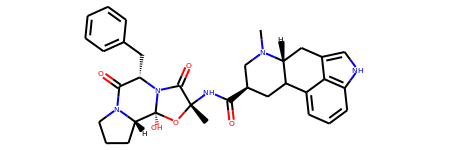

In [189]:
m1 = Chem.MolFromSmiles(d1[0])
m1

In [190]:
d2 = drugs_mu_dict['Ergotamine']

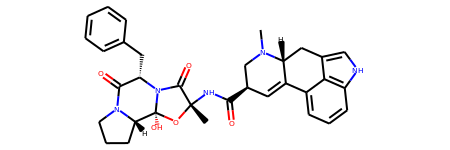

In [191]:
m2 = Chem.MolFromSmiles(d2[0])
m2

In [173]:
d3 = drugs_mu_dict['Flurandrenolide']

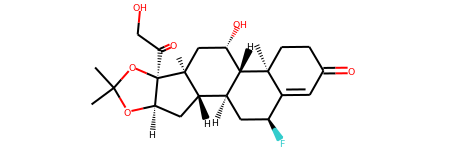

In [174]:
m3 = Chem.MolFromSmiles(d3[0])
m3

### Clusters in 2D

In [181]:
# radius (poincare ball)
radius = np.linalg.norm(latent_lor_reps, ord=2, axis=1)

# dimension reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(latent_poi_reps)

# clustering
ncluster = 14
hcluster = AgglomerativeClustering(n_clusters = ncluster, affinity='precomputed', linkage='complete')
cluster_lor = hcluster.fit(lor_dist_mtrx)
cluster_labels = cluster_lor.labels_

In [182]:
# Step 4: create a dataframe for visualization
embedding_cluster_lst = []
idx = 0
for k in drugs_mu_dict.keys():
    key = k.lower()
    x1 = embedding[idx,0]
    x2 = embedding[idx,1]
    smile_x = drugs_mu_dict[k][0]
    smile_g = drugs_mu_dict[k][1]
    c = cluster_labels[idx]
    embedding_cluster_lst.append([key, x1, x2, smile_x, smile_g, c])
    idx += 1
embedding_cluster_df = pd.DataFrame(embedding_cluster_lst, \
                                    columns=['active_ingredient','x1','x2','smile_x','smile_g','cluster'])


In [183]:
scatter = hv.Scatter(embedding_cluster_df, 'x1',vdims=['x2','cluster','active_ingredient','smile_x','smile_g'])
scatter.opts(width=900, height=600, size=5, color='cluster', show_legend=False, cmap='tab20')

:Scatter   [x1]   (x2,cluster,active_ingredient,smile_x,smile_g)

In [168]:
while 1<2:
    pass

KeyboardInterrupt: 